In [1]:
from tensorflow import keras
keras.__version__

'2.5.0'

In [2]:
import tensorflow as tf
tf.__version__

'2.5.0'

In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [4]:
tf.debugging.set_log_device_placement(True)

with tf.device('/GPU:0'):
  a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
  b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])

c = tf.matmul(a, b)
print(c)

Executing op MatMul in device /job:localhost/replica:0/task:0/device:GPU:0
tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


In [5]:
import tensorflow as tf

tf.compat.v1.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [6]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array, save_img

# 변환하려는 이미지 경로
target_image_path = './datasets/portrait.png'
# 스타일 이미지 경로
style_reference_image_path = './datasets/StarryNight.jpg'

# 생성된 사진의 차원
width, height = load_img(target_image_path).size
img_height = 400
img_width = int(width * img_height / height)

In [7]:
import numpy as np
from tensorflow.keras.applications import vgg19

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_height, img_width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

def deprocess_image(x):
    # ImageNet의 평균 픽셀 값을 더함
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [8]:
from tensorflow.keras import backend as K

target_image = K.constant(preprocess_image(target_image_path))
style_reference_image = K.constant(preprocess_image(style_reference_image_path))

# 생성된 이미지를 담을 플레이스홀더
combination_image = K.placeholder((1, img_height, img_width, 3))

# 세 개의 이미지를 하나의 배치로 합침
input_tensor = K.concatenate([target_image,
                              style_reference_image,
                              combination_image], axis=0)

# 세 이미지의 배치를 입력으로 받는 VGG 네트워크를 만듦
# 이 모델은 사전 훈련된 ImageNet 가중치를 로드
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet',
                    include_top=False)
print('모델 로드 완료.')

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA TITAN RTX, pci bus id: 0000:67:00.0, compute capability: 7.5
/job:localhost/replica:0/task:0/device:GPU:1 -> device: 1, name: NVIDIA TITAN RTX, pci bus id: 0000:68:00.0, compute capability: 7.5

모델 로드 완료.


In [9]:
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

In [10]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram


def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_height * img_width
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

In [11]:
def total_variation_loss(x):
    a = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, 1:, :img_width - 1, :])
    b = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, :img_height - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

In [12]:
# 층 이름과 활성화 텐서를 매핑한 딕셔너리
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
# 콘텐츠 손실에 사용할 층
content_layer = 'block5_conv2'
# 스타일 손실에 사용할 층
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']
# 손실 항목의 가중치 평균에 사용할 가중치
total_variation_weight = 1e-4
style_weight = 1.
content_weight = 0.025

# 모든 손실 요소를 더해 하나의 스칼라 변수로 손실을 정의
loss = K.variable(0.)
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss = loss + content_weight * content_loss(target_image_features,
                                      combination_features)
for layer_name in style_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss = loss + (style_weight / len(style_layers)) * sl
loss = loss + total_variation_weight * total_variation_loss(combination_image)

In [13]:
# 손실에 대한 생성된 이미지의 그래디언트를 구함
grads = K.gradients(loss, combination_image)[0]

# 현재 손실과 그래디언트의 값을 추출하는 케라스 Function 객체
fetch_loss_and_grads = K.function([combination_image], [loss, grads])


class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1, img_height, img_width, 3))
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

In [14]:
from scipy.optimize import fmin_l_bfgs_b
import time

result_prefix = 'style_transfer_result'
iterations = 10000

# 뉴럴 스타일 트랜스퍼의 손실을 최소화하기 위해 생성된 이미지에 대해 L-BFGS 최적화를 수행
# 초기 값은 타깃 이미지
# scipy.optimize.fmin_l_bfgs_b 함수가 벡터만 처리할 수 있기 때문에 이미지를 펼침
x = preprocess_image(target_image_path)
x = x.flatten()
for i in range(iterations):
    print('반복 횟수:', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x,
                                     fprime=evaluator.grads, maxfun=20)
    print('현재 손실 값:', min_val)
    # 생성된 현재 이미지를 저장
    img = x.copy().reshape((img_height, img_width, 3))
    img = deprocess_image(img)
    fname = result_prefix + '_at_iteration_%d.png' % i
    save_img(fname, img)
    end_time = time.time()
    print('저장 이미지: ', fname)
    print('%d 번째 반복 완료: %ds' % (i, end_time - start_time))

반복 횟수: 0
현재 손실 값: 2027153800.0
저장 이미지:  style_transfer_result_at_iteration_0.png
0 번째 반복 완료: 5s
반복 횟수: 1
현재 손실 값: 1050753300.0
저장 이미지:  style_transfer_result_at_iteration_1.png
1 번째 반복 완료: 2s
반복 횟수: 2
현재 손실 값: 783500600.0
저장 이미지:  style_transfer_result_at_iteration_2.png
2 번째 반복 완료: 2s
반복 횟수: 3
현재 손실 값: 633795000.0
저장 이미지:  style_transfer_result_at_iteration_3.png
3 번째 반복 완료: 2s
반복 횟수: 4
현재 손실 값: 522985900.0
저장 이미지:  style_transfer_result_at_iteration_4.png
4 번째 반복 완료: 2s
반복 횟수: 5
현재 손실 값: 456987680.0
저장 이미지:  style_transfer_result_at_iteration_5.png
5 번째 반복 완료: 2s
반복 횟수: 6
현재 손실 값: 408735970.0
저장 이미지:  style_transfer_result_at_iteration_6.png
6 번째 반복 완료: 2s
반복 횟수: 7
현재 손실 값: 370061470.0
저장 이미지:  style_transfer_result_at_iteration_7.png
7 번째 반복 완료: 2s
반복 횟수: 8
현재 손실 값: 346120670.0
저장 이미지:  style_transfer_result_at_iteration_8.png
8 번째 반복 완료: 2s
반복 횟수: 9
현재 손실 값: 319688060.0
저장 이미지:  style_transfer_result_at_iteration_9.png
9 번째 반복 완료: 2s
반복 횟수: 10
현재 손실 값: 298356100.0
저장 이미지:  style_tr

현재 손실 값: 56871788.0
저장 이미지:  style_transfer_result_at_iteration_85.png
85 번째 반복 완료: 2s
반복 횟수: 86
현재 손실 값: 56358260.0
저장 이미지:  style_transfer_result_at_iteration_86.png
86 번째 반복 완료: 2s
반복 횟수: 87
현재 손실 값: 55915116.0
저장 이미지:  style_transfer_result_at_iteration_87.png
87 번째 반복 완료: 2s
반복 횟수: 88
현재 손실 값: 55427690.0
저장 이미지:  style_transfer_result_at_iteration_88.png
88 번째 반복 완료: 2s
반복 횟수: 89
현재 손실 값: 55007950.0
저장 이미지:  style_transfer_result_at_iteration_89.png
89 번째 반복 완료: 2s
반복 횟수: 90
현재 손실 값: 54633750.0
저장 이미지:  style_transfer_result_at_iteration_90.png
90 번째 반복 완료: 2s
반복 횟수: 91
현재 손실 값: 54288596.0
저장 이미지:  style_transfer_result_at_iteration_91.png
91 번째 반복 완료: 2s
반복 횟수: 92
현재 손실 값: 53937910.0
저장 이미지:  style_transfer_result_at_iteration_92.png
92 번째 반복 완료: 2s
반복 횟수: 93
현재 손실 값: 53396290.0
저장 이미지:  style_transfer_result_at_iteration_93.png
93 번째 반복 완료: 2s
반복 횟수: 94
현재 손실 값: 53022356.0
저장 이미지:  style_transfer_result_at_iteration_94.png
94 번째 반복 완료: 2s
반복 횟수: 95
현재 손실 값: 52601350.0
저장 이미지:  s

현재 손실 값: 36683464.0
저장 이미지:  style_transfer_result_at_iteration_168.png
168 번째 반복 완료: 2s
반복 횟수: 169
현재 손실 값: 36515320.0
저장 이미지:  style_transfer_result_at_iteration_169.png
169 번째 반복 완료: 2s
반복 횟수: 170
현재 손실 값: 36352404.0
저장 이미지:  style_transfer_result_at_iteration_170.png
170 번째 반복 완료: 2s
반복 횟수: 171
현재 손실 값: 36175544.0
저장 이미지:  style_transfer_result_at_iteration_171.png
171 번째 반복 완료: 2s
반복 횟수: 172
현재 손실 값: 36010664.0
저장 이미지:  style_transfer_result_at_iteration_172.png
172 번째 반복 완료: 2s
반복 횟수: 173
현재 손실 값: 35887292.0
저장 이미지:  style_transfer_result_at_iteration_173.png
173 번째 반복 완료: 2s
반복 횟수: 174
현재 손실 값: 35764628.0
저장 이미지:  style_transfer_result_at_iteration_174.png
174 번째 반복 완료: 2s
반복 횟수: 175
현재 손실 값: 35670444.0
저장 이미지:  style_transfer_result_at_iteration_175.png
175 번째 반복 완료: 2s
반복 횟수: 176
현재 손실 값: 35577748.0
저장 이미지:  style_transfer_result_at_iteration_176.png
176 번째 반복 완료: 2s
반복 횟수: 177
현재 손실 값: 35503984.0
저장 이미지:  style_transfer_result_at_iteration_177.png
177 번째 반복 완료: 2s
반복 횟수: 178


현재 손실 값: 29935174.0
저장 이미지:  style_transfer_result_at_iteration_250.png
250 번째 반복 완료: 2s
반복 횟수: 251
현재 손실 값: 29860468.0
저장 이미지:  style_transfer_result_at_iteration_251.png
251 번째 반복 완료: 2s
반복 횟수: 252
현재 손실 값: 29810206.0
저장 이미지:  style_transfer_result_at_iteration_252.png
252 번째 반복 완료: 2s
반복 횟수: 253
현재 손실 값: 29760560.0
저장 이미지:  style_transfer_result_at_iteration_253.png
253 번째 반복 완료: 2s
반복 횟수: 254
현재 손실 값: 29719440.0
저장 이미지:  style_transfer_result_at_iteration_254.png
254 번째 반복 완료: 2s
반복 횟수: 255
현재 손실 값: 29653808.0
저장 이미지:  style_transfer_result_at_iteration_255.png
255 번째 반복 완료: 2s
반복 횟수: 256
현재 손실 값: 29597836.0
저장 이미지:  style_transfer_result_at_iteration_256.png
256 번째 반복 완료: 2s
반복 횟수: 257
현재 손실 값: 29539532.0
저장 이미지:  style_transfer_result_at_iteration_257.png
257 번째 반복 완료: 2s
반복 횟수: 258
현재 손실 값: 29490964.0
저장 이미지:  style_transfer_result_at_iteration_258.png
258 번째 반복 완료: 2s
반복 횟수: 259
현재 손실 값: 29447168.0
저장 이미지:  style_transfer_result_at_iteration_259.png
259 번째 반복 완료: 2s
반복 횟수: 260


현재 손실 값: 26618954.0
저장 이미지:  style_transfer_result_at_iteration_332.png
332 번째 반복 완료: 2s
반복 횟수: 333
현재 손실 값: 26583302.0
저장 이미지:  style_transfer_result_at_iteration_333.png
333 번째 반복 완료: 2s
반복 횟수: 334
현재 손실 값: 26540222.0
저장 이미지:  style_transfer_result_at_iteration_334.png
334 번째 반복 완료: 2s
반복 횟수: 335
현재 손실 값: 26496524.0
저장 이미지:  style_transfer_result_at_iteration_335.png
335 번째 반복 완료: 2s
반복 횟수: 336
현재 손실 값: 26463144.0
저장 이미지:  style_transfer_result_at_iteration_336.png
336 번째 반복 완료: 2s
반복 횟수: 337
현재 손실 값: 26427932.0
저장 이미지:  style_transfer_result_at_iteration_337.png
337 번째 반복 완료: 2s
반복 횟수: 338
현재 손실 값: 26404546.0
저장 이미지:  style_transfer_result_at_iteration_338.png
338 번째 반복 완료: 2s
반복 횟수: 339
현재 손실 값: 26380860.0
저장 이미지:  style_transfer_result_at_iteration_339.png
339 번째 반복 완료: 2s
반복 횟수: 340
현재 손실 값: 26351124.0
저장 이미지:  style_transfer_result_at_iteration_340.png
340 번째 반복 완료: 2s
반복 횟수: 341
현재 손실 값: 26322184.0
저장 이미지:  style_transfer_result_at_iteration_341.png
341 번째 반복 완료: 2s
반복 횟수: 342


현재 손실 값: 24499894.0
저장 이미지:  style_transfer_result_at_iteration_414.png
414 번째 반복 완료: 2s
반복 횟수: 415
현재 손실 값: 24483780.0
저장 이미지:  style_transfer_result_at_iteration_415.png
415 번째 반복 완료: 2s
반복 횟수: 416
현재 손실 값: 24462762.0
저장 이미지:  style_transfer_result_at_iteration_416.png
416 번째 반복 완료: 2s
반복 횟수: 417
현재 손실 값: 24441026.0
저장 이미지:  style_transfer_result_at_iteration_417.png
417 번째 반복 완료: 2s
반복 횟수: 418
현재 손실 값: 24422508.0
저장 이미지:  style_transfer_result_at_iteration_418.png
418 번째 반복 완료: 2s
반복 횟수: 419
현재 손실 값: 24403912.0
저장 이미지:  style_transfer_result_at_iteration_419.png
419 번째 반복 완료: 2s
반복 횟수: 420
현재 손실 값: 24387820.0
저장 이미지:  style_transfer_result_at_iteration_420.png
420 번째 반복 완료: 2s
반복 횟수: 421
현재 손실 값: 24369990.0
저장 이미지:  style_transfer_result_at_iteration_421.png
421 번째 반복 완료: 2s
반복 횟수: 422
현재 손실 값: 24353430.0
저장 이미지:  style_transfer_result_at_iteration_422.png
422 번째 반복 완료: 2s
반복 횟수: 423
현재 손실 값: 24337308.0
저장 이미지:  style_transfer_result_at_iteration_423.png
423 번째 반복 완료: 2s
반복 횟수: 424


현재 손실 값: 23125870.0
저장 이미지:  style_transfer_result_at_iteration_496.png
496 번째 반복 완료: 2s
반복 횟수: 497
현재 손실 값: 23110422.0
저장 이미지:  style_transfer_result_at_iteration_497.png
497 번째 반복 완료: 2s
반복 횟수: 498
현재 손실 값: 23090790.0
저장 이미지:  style_transfer_result_at_iteration_498.png
498 번째 반복 완료: 2s
반복 횟수: 499
현재 손실 값: 23073568.0
저장 이미지:  style_transfer_result_at_iteration_499.png
499 번째 반복 완료: 2s
반복 횟수: 500
현재 손실 값: 23054868.0
저장 이미지:  style_transfer_result_at_iteration_500.png
500 번째 반복 완료: 2s
반복 횟수: 501
현재 손실 값: 23032456.0
저장 이미지:  style_transfer_result_at_iteration_501.png
501 번째 반복 완료: 2s
반복 횟수: 502
현재 손실 값: 23019416.0
저장 이미지:  style_transfer_result_at_iteration_502.png
502 번째 반복 완료: 2s
반복 횟수: 503
현재 손실 값: 23005048.0
저장 이미지:  style_transfer_result_at_iteration_503.png
503 번째 반복 완료: 2s
반복 횟수: 504
현재 손실 값: 22994000.0
저장 이미지:  style_transfer_result_at_iteration_504.png
504 번째 반복 완료: 2s
반복 횟수: 505
현재 손실 값: 22982328.0
저장 이미지:  style_transfer_result_at_iteration_505.png
505 번째 반복 완료: 2s
반복 횟수: 506


현재 손실 값: 22002884.0
저장 이미지:  style_transfer_result_at_iteration_578.png
578 번째 반복 완료: 2s
반복 횟수: 579
현재 손실 값: 21993996.0
저장 이미지:  style_transfer_result_at_iteration_579.png
579 번째 반복 완료: 2s
반복 횟수: 580
현재 손실 값: 21986404.0
저장 이미지:  style_transfer_result_at_iteration_580.png
580 번째 반복 완료: 2s
반복 횟수: 581
현재 손실 값: 21978306.0
저장 이미지:  style_transfer_result_at_iteration_581.png
581 번째 반복 완료: 2s
반복 횟수: 582
현재 손실 값: 21969460.0
저장 이미지:  style_transfer_result_at_iteration_582.png
582 번째 반복 완료: 2s
반복 횟수: 583
현재 손실 값: 21960968.0
저장 이미지:  style_transfer_result_at_iteration_583.png
583 번째 반복 완료: 2s
반복 횟수: 584
현재 손실 값: 21952640.0
저장 이미지:  style_transfer_result_at_iteration_584.png
584 번째 반복 완료: 2s
반복 횟수: 585
현재 손실 값: 21943636.0
저장 이미지:  style_transfer_result_at_iteration_585.png
585 번째 반복 완료: 2s
반복 횟수: 586
현재 손실 값: 21935676.0
저장 이미지:  style_transfer_result_at_iteration_586.png
586 번째 반복 완료: 2s
반복 횟수: 587
현재 손실 값: 21927050.0
저장 이미지:  style_transfer_result_at_iteration_587.png
587 번째 반복 완료: 2s
반복 횟수: 588


현재 손실 값: 21199116.0
저장 이미지:  style_transfer_result_at_iteration_660.png
660 번째 반복 완료: 2s
반복 횟수: 661
현재 손실 값: 21190918.0
저장 이미지:  style_transfer_result_at_iteration_661.png
661 번째 반복 완료: 2s
반복 횟수: 662
현재 손실 값: 21182898.0
저장 이미지:  style_transfer_result_at_iteration_662.png
662 번째 반복 완료: 2s
반복 횟수: 663
현재 손실 값: 21172074.0
저장 이미지:  style_transfer_result_at_iteration_663.png
663 번째 반복 완료: 2s
반복 횟수: 664
현재 손실 값: 21159912.0
저장 이미지:  style_transfer_result_at_iteration_664.png
664 번째 반복 완료: 2s
반복 횟수: 665
현재 손실 값: 21148570.0
저장 이미지:  style_transfer_result_at_iteration_665.png
665 번째 반복 완료: 2s
반복 횟수: 666
현재 손실 값: 21138266.0
저장 이미지:  style_transfer_result_at_iteration_666.png
666 번째 반복 완료: 2s
반복 횟수: 667
현재 손실 값: 21132332.0
저장 이미지:  style_transfer_result_at_iteration_667.png
667 번째 반복 완료: 2s
반복 횟수: 668
현재 손실 값: 21124512.0
저장 이미지:  style_transfer_result_at_iteration_668.png
668 번째 반복 완료: 2s
반복 횟수: 669
현재 손실 값: 21117158.0
저장 이미지:  style_transfer_result_at_iteration_669.png
669 번째 반복 완료: 2s
반복 횟수: 670


현재 손실 값: 20572168.0
저장 이미지:  style_transfer_result_at_iteration_742.png
742 번째 반복 완료: 2s
반복 횟수: 743
현재 손실 값: 20564114.0
저장 이미지:  style_transfer_result_at_iteration_743.png
743 번째 반복 완료: 2s
반복 횟수: 744
현재 손실 값: 20556676.0
저장 이미지:  style_transfer_result_at_iteration_744.png
744 번째 반복 완료: 2s
반복 횟수: 745
현재 손실 값: 20549328.0
저장 이미지:  style_transfer_result_at_iteration_745.png
745 번째 반복 완료: 2s
반복 횟수: 746
현재 손실 값: 20540790.0
저장 이미지:  style_transfer_result_at_iteration_746.png
746 번째 반복 완료: 2s
반복 횟수: 747
현재 손실 값: 20528180.0
저장 이미지:  style_transfer_result_at_iteration_747.png
747 번째 반복 완료: 2s
반복 횟수: 748
현재 손실 값: 20521848.0
저장 이미지:  style_transfer_result_at_iteration_748.png
748 번째 반복 완료: 2s
반복 횟수: 749
현재 손실 값: 20515142.0
저장 이미지:  style_transfer_result_at_iteration_749.png
749 번째 반복 완료: 2s
반복 횟수: 750
현재 손실 값: 20508522.0
저장 이미지:  style_transfer_result_at_iteration_750.png
750 번째 반복 완료: 2s
반복 횟수: 751
현재 손실 값: 20502510.0
저장 이미지:  style_transfer_result_at_iteration_751.png
751 번째 반복 완료: 2s
반복 횟수: 752


현재 손실 값: 20026576.0
저장 이미지:  style_transfer_result_at_iteration_824.png
824 번째 반복 완료: 2s
반복 횟수: 825
현재 손실 값: 20020592.0
저장 이미지:  style_transfer_result_at_iteration_825.png
825 번째 반복 완료: 2s
반복 횟수: 826
현재 손실 값: 20013056.0
저장 이미지:  style_transfer_result_at_iteration_826.png
826 번째 반복 완료: 2s
반복 횟수: 827
현재 손실 값: 20004078.0
저장 이미지:  style_transfer_result_at_iteration_827.png
827 번째 반복 완료: 2s
반복 횟수: 828
현재 손실 값: 19998842.0
저장 이미지:  style_transfer_result_at_iteration_828.png
828 번째 반복 완료: 2s
반복 횟수: 829
현재 손실 값: 19993976.0
저장 이미지:  style_transfer_result_at_iteration_829.png
829 번째 반복 완료: 2s
반복 횟수: 830
현재 손실 값: 19987010.0
저장 이미지:  style_transfer_result_at_iteration_830.png
830 번째 반복 완료: 2s
반복 횟수: 831
현재 손실 값: 19978188.0
저장 이미지:  style_transfer_result_at_iteration_831.png
831 번째 반복 완료: 2s
반복 횟수: 832
현재 손실 값: 19971666.0
저장 이미지:  style_transfer_result_at_iteration_832.png
832 번째 반복 완료: 2s
반복 횟수: 833
현재 손실 값: 19963400.0
저장 이미지:  style_transfer_result_at_iteration_833.png
833 번째 반복 완료: 2s
반복 횟수: 834


현재 손실 값: 19577188.0
저장 이미지:  style_transfer_result_at_iteration_906.png
906 번째 반복 완료: 2s
반복 횟수: 907
현재 손실 값: 19571724.0
저장 이미지:  style_transfer_result_at_iteration_907.png
907 번째 반복 완료: 2s
반복 횟수: 908
현재 손실 값: 19566458.0
저장 이미지:  style_transfer_result_at_iteration_908.png
908 번째 반복 완료: 2s
반복 횟수: 909
현재 손실 값: 19561012.0
저장 이미지:  style_transfer_result_at_iteration_909.png
909 번째 반복 완료: 2s
반복 횟수: 910
현재 손실 값: 19554310.0
저장 이미지:  style_transfer_result_at_iteration_910.png
910 번째 반복 완료: 2s
반복 횟수: 911
현재 손실 값: 19546600.0
저장 이미지:  style_transfer_result_at_iteration_911.png
911 번째 반복 완료: 2s
반복 횟수: 912
현재 손실 값: 19542494.0
저장 이미지:  style_transfer_result_at_iteration_912.png
912 번째 반복 완료: 2s
반복 횟수: 913
현재 손실 값: 19538484.0
저장 이미지:  style_transfer_result_at_iteration_913.png
913 번째 반복 완료: 2s
반복 횟수: 914
현재 손실 값: 19533356.0
저장 이미지:  style_transfer_result_at_iteration_914.png
914 번째 반복 완료: 2s
반복 횟수: 915
현재 손실 값: 19527804.0
저장 이미지:  style_transfer_result_at_iteration_915.png
915 번째 반복 완료: 2s
반복 횟수: 916


현재 손실 값: 19191578.0
저장 이미지:  style_transfer_result_at_iteration_988.png
988 번째 반복 완료: 2s
반복 횟수: 989
현재 손실 값: 19188154.0
저장 이미지:  style_transfer_result_at_iteration_989.png
989 번째 반복 완료: 2s
반복 횟수: 990
현재 손실 값: 19184730.0
저장 이미지:  style_transfer_result_at_iteration_990.png
990 번째 반복 완료: 2s
반복 횟수: 991
현재 손실 값: 19180920.0
저장 이미지:  style_transfer_result_at_iteration_991.png
991 번째 반복 완료: 2s
반복 횟수: 992
현재 손실 값: 19177624.0
저장 이미지:  style_transfer_result_at_iteration_992.png
992 번째 반복 완료: 2s
반복 횟수: 993
현재 손실 값: 19173624.0
저장 이미지:  style_transfer_result_at_iteration_993.png
993 번째 반복 완료: 2s
반복 횟수: 994
현재 손실 값: 19169298.0
저장 이미지:  style_transfer_result_at_iteration_994.png
994 번째 반복 완료: 2s
반복 횟수: 995
현재 손실 값: 19164616.0
저장 이미지:  style_transfer_result_at_iteration_995.png
995 번째 반복 완료: 2s
반복 횟수: 996
현재 손실 값: 19159752.0
저장 이미지:  style_transfer_result_at_iteration_996.png
996 번째 반복 완료: 2s
반복 횟수: 997
현재 손실 값: 19155978.0
저장 이미지:  style_transfer_result_at_iteration_997.png
997 번째 반복 완료: 2s
반복 횟수: 998


현재 손실 값: 18874726.0
저장 이미지:  style_transfer_result_at_iteration_1068.png
1068 번째 반복 완료: 2s
반복 횟수: 1069
현재 손실 값: 18871550.0
저장 이미지:  style_transfer_result_at_iteration_1069.png
1069 번째 반복 완료: 2s
반복 횟수: 1070
현재 손실 값: 18867234.0
저장 이미지:  style_transfer_result_at_iteration_1070.png
1070 번째 반복 완료: 2s
반복 횟수: 1071
현재 손실 값: 18864090.0
저장 이미지:  style_transfer_result_at_iteration_1071.png
1071 번째 반복 완료: 2s
반복 횟수: 1072
현재 손실 값: 18860774.0
저장 이미지:  style_transfer_result_at_iteration_1072.png
1072 번째 반복 완료: 2s
반복 횟수: 1073
현재 손실 값: 18857366.0
저장 이미지:  style_transfer_result_at_iteration_1073.png
1073 번째 반복 완료: 2s
반복 횟수: 1074
현재 손실 값: 18853958.0
저장 이미지:  style_transfer_result_at_iteration_1074.png
1074 번째 반복 완료: 2s
반복 횟수: 1075
현재 손실 값: 18849576.0
저장 이미지:  style_transfer_result_at_iteration_1075.png
1075 번째 반복 완료: 2s
반복 횟수: 1076
현재 손실 값: 18844220.0
저장 이미지:  style_transfer_result_at_iteration_1076.png
1076 번째 반복 완료: 2s
반복 횟수: 1077
현재 손실 값: 18840676.0
저장 이미지:  style_transfer_result_at_iteration_1077.png


현재 손실 값: 18601916.0
저장 이미지:  style_transfer_result_at_iteration_1148.png
1148 번째 반복 완료: 2s
반복 횟수: 1149
현재 손실 값: 18599160.0
저장 이미지:  style_transfer_result_at_iteration_1149.png
1149 번째 반복 완료: 2s
반복 횟수: 1150
현재 손실 값: 18596026.0
저장 이미지:  style_transfer_result_at_iteration_1150.png
1150 번째 반복 완료: 2s
반복 횟수: 1151
현재 손실 값: 18593334.0
저장 이미지:  style_transfer_result_at_iteration_1151.png
1151 번째 반복 완료: 2s
반복 횟수: 1152
현재 손실 값: 18590178.0
저장 이미지:  style_transfer_result_at_iteration_1152.png
1152 번째 반복 완료: 2s
반복 횟수: 1153
현재 손실 값: 18587578.0
저장 이미지:  style_transfer_result_at_iteration_1153.png
1153 번째 반복 완료: 2s
반복 횟수: 1154
현재 손실 값: 18584262.0
저장 이미지:  style_transfer_result_at_iteration_1154.png
1154 번째 반복 완료: 2s
반복 횟수: 1155
현재 손실 값: 18581580.0
저장 이미지:  style_transfer_result_at_iteration_1155.png
1155 번째 반복 완료: 2s
반복 횟수: 1156
현재 손실 값: 18578754.0
저장 이미지:  style_transfer_result_at_iteration_1156.png
1156 번째 반복 완료: 2s
반복 횟수: 1157
현재 손실 값: 18576454.0
저장 이미지:  style_transfer_result_at_iteration_1157.png


현재 손실 값: 18359674.0
저장 이미지:  style_transfer_result_at_iteration_1228.png
1228 번째 반복 완료: 2s
반복 횟수: 1229
현재 손실 값: 18356928.0
저장 이미지:  style_transfer_result_at_iteration_1229.png
1229 번째 반복 완료: 2s
반복 횟수: 1230
현재 손실 값: 18353812.0
저장 이미지:  style_transfer_result_at_iteration_1230.png
1230 번째 반복 완료: 2s
반복 횟수: 1231
현재 손실 값: 18350768.0
저장 이미지:  style_transfer_result_at_iteration_1231.png
1231 번째 반복 완료: 2s
반복 횟수: 1232
현재 손실 값: 18347042.0
저장 이미지:  style_transfer_result_at_iteration_1232.png
1232 번째 반복 완료: 2s
반복 횟수: 1233
현재 손실 값: 18344024.0
저장 이미지:  style_transfer_result_at_iteration_1233.png
1233 번째 반복 완료: 2s
반복 횟수: 1234
현재 손실 값: 18340476.0
저장 이미지:  style_transfer_result_at_iteration_1234.png
1234 번째 반복 완료: 2s
반복 횟수: 1235
현재 손실 값: 18338324.0
저장 이미지:  style_transfer_result_at_iteration_1235.png
1235 번째 반복 완료: 2s
반복 횟수: 1236
현재 손실 값: 18335672.0
저장 이미지:  style_transfer_result_at_iteration_1236.png
1236 번째 반복 완료: 2s
반복 횟수: 1237
현재 손실 값: 18333206.0
저장 이미지:  style_transfer_result_at_iteration_1237.png


현재 손실 값: 18120958.0
저장 이미지:  style_transfer_result_at_iteration_1308.png
1308 번째 반복 완료: 2s
반복 횟수: 1309
현재 손실 값: 18118000.0
저장 이미지:  style_transfer_result_at_iteration_1309.png
1309 번째 반복 완료: 2s
반복 횟수: 1310
현재 손실 값: 18114096.0
저장 이미지:  style_transfer_result_at_iteration_1310.png
1310 번째 반복 완료: 2s
반복 횟수: 1311
현재 손실 값: 18111532.0
저장 이미지:  style_transfer_result_at_iteration_1311.png
1311 번째 반복 완료: 2s
반복 횟수: 1312
현재 손실 값: 18108768.0
저장 이미지:  style_transfer_result_at_iteration_1312.png
1312 번째 반복 완료: 2s
반복 횟수: 1313
현재 손실 값: 18105956.0
저장 이미지:  style_transfer_result_at_iteration_1313.png
1313 번째 반복 완료: 2s
반복 횟수: 1314
현재 손실 값: 18102852.0
저장 이미지:  style_transfer_result_at_iteration_1314.png
1314 번째 반복 완료: 2s
반복 횟수: 1315
현재 손실 값: 18099942.0
저장 이미지:  style_transfer_result_at_iteration_1315.png
1315 번째 반복 완료: 2s
반복 횟수: 1316
현재 손실 값: 18096776.0
저장 이미지:  style_transfer_result_at_iteration_1316.png
1316 번째 반복 완료: 2s
반복 횟수: 1317
현재 손실 값: 18093668.0
저장 이미지:  style_transfer_result_at_iteration_1317.png


현재 손실 값: 17903274.0
저장 이미지:  style_transfer_result_at_iteration_1388.png
1388 번째 반복 완료: 2s
반복 횟수: 1389
현재 손실 값: 17900040.0
저장 이미지:  style_transfer_result_at_iteration_1389.png
1389 번째 반복 완료: 2s
반복 횟수: 1390
현재 손실 값: 17897900.0
저장 이미지:  style_transfer_result_at_iteration_1390.png
1390 번째 반복 완료: 2s
반복 횟수: 1391
현재 손실 값: 17895508.0
저장 이미지:  style_transfer_result_at_iteration_1391.png
1391 번째 반복 완료: 2s
반복 횟수: 1392
현재 손실 값: 17892726.0
저장 이미지:  style_transfer_result_at_iteration_1392.png
1392 번째 반복 완료: 2s
반복 횟수: 1393
현재 손실 값: 17888836.0
저장 이미지:  style_transfer_result_at_iteration_1393.png
1393 번째 반복 완료: 2s
반복 횟수: 1394
현재 손실 값: 17886632.0
저장 이미지:  style_transfer_result_at_iteration_1394.png
1394 번째 반복 완료: 2s
반복 횟수: 1395
현재 손실 값: 17884086.0
저장 이미지:  style_transfer_result_at_iteration_1395.png
1395 번째 반복 완료: 2s
반복 횟수: 1396
현재 손실 값: 17881610.0
저장 이미지:  style_transfer_result_at_iteration_1396.png
1396 번째 반복 완료: 2s
반복 횟수: 1397
현재 손실 값: 17878982.0
저장 이미지:  style_transfer_result_at_iteration_1397.png


현재 손실 값: 17717938.0
저장 이미지:  style_transfer_result_at_iteration_1468.png
1468 번째 반복 완료: 2s
반복 횟수: 1469
현재 손실 값: 17715958.0
저장 이미지:  style_transfer_result_at_iteration_1469.png
1469 번째 반복 완료: 2s
반복 횟수: 1470
현재 손실 값: 17714248.0
저장 이미지:  style_transfer_result_at_iteration_1470.png
1470 번째 반복 완료: 2s
반복 횟수: 1471
현재 손실 값: 17712402.0
저장 이미지:  style_transfer_result_at_iteration_1471.png
1471 번째 반복 완료: 2s
반복 횟수: 1472
현재 손실 값: 17710672.0
저장 이미지:  style_transfer_result_at_iteration_1472.png
1472 번째 반복 완료: 2s
반복 횟수: 1473
현재 손실 값: 17708852.0
저장 이미지:  style_transfer_result_at_iteration_1473.png
1473 번째 반복 완료: 2s
반복 횟수: 1474
현재 손실 값: 17707306.0
저장 이미지:  style_transfer_result_at_iteration_1474.png
1474 번째 반복 완료: 2s
반복 횟수: 1475
현재 손실 값: 17705394.0
저장 이미지:  style_transfer_result_at_iteration_1475.png
1475 번째 반복 완료: 2s
반복 횟수: 1476
현재 손실 값: 17702818.0
저장 이미지:  style_transfer_result_at_iteration_1476.png
1476 번째 반복 완료: 2s
반복 횟수: 1477
현재 손실 값: 17699260.0
저장 이미지:  style_transfer_result_at_iteration_1477.png


현재 손실 값: 17559112.0
저장 이미지:  style_transfer_result_at_iteration_1548.png
1548 번째 반복 완료: 2s
반복 횟수: 1549
현재 손실 값: 17557530.0
저장 이미지:  style_transfer_result_at_iteration_1549.png
1549 번째 반복 완료: 2s
반복 횟수: 1550
현재 손실 값: 17555756.0
저장 이미지:  style_transfer_result_at_iteration_1550.png
1550 번째 반복 완료: 2s
반복 횟수: 1551
현재 손실 값: 17554130.0
저장 이미지:  style_transfer_result_at_iteration_1551.png
1551 번째 반복 완료: 2s
반복 횟수: 1552
현재 손실 값: 17552182.0
저장 이미지:  style_transfer_result_at_iteration_1552.png
1552 번째 반복 완료: 2s
반복 횟수: 1553
현재 손실 값: 17550376.0
저장 이미지:  style_transfer_result_at_iteration_1553.png
1553 번째 반복 완료: 2s
반복 횟수: 1554
현재 손실 값: 17548164.0
저장 이미지:  style_transfer_result_at_iteration_1554.png
1554 번째 반복 완료: 2s
반복 횟수: 1555
현재 손실 값: 17546840.0
저장 이미지:  style_transfer_result_at_iteration_1555.png
1555 번째 반복 완료: 2s
반복 횟수: 1556
현재 손실 값: 17545174.0
저장 이미지:  style_transfer_result_at_iteration_1556.png
1556 번째 반복 완료: 2s
반복 횟수: 1557
현재 손실 값: 17543776.0
저장 이미지:  style_transfer_result_at_iteration_1557.png


현재 손실 값: 17429210.0
저장 이미지:  style_transfer_result_at_iteration_1628.png
1628 번째 반복 완료: 2s
반복 횟수: 1629
현재 손실 값: 17427736.0
저장 이미지:  style_transfer_result_at_iteration_1629.png
1629 번째 반복 완료: 2s
반복 횟수: 1630
현재 손실 값: 17426320.0
저장 이미지:  style_transfer_result_at_iteration_1630.png
1630 번째 반복 완료: 2s
반복 횟수: 1631
현재 손실 값: 17424878.0
저장 이미지:  style_transfer_result_at_iteration_1631.png
1631 번째 반복 완료: 2s
반복 횟수: 1632
현재 손실 값: 17423146.0
저장 이미지:  style_transfer_result_at_iteration_1632.png
1632 번째 반복 완료: 2s
반복 횟수: 1633
현재 손실 값: 17421654.0
저장 이미지:  style_transfer_result_at_iteration_1633.png
1633 번째 반복 완료: 2s
반복 횟수: 1634
현재 손실 값: 17419626.0
저장 이미지:  style_transfer_result_at_iteration_1634.png
1634 번째 반복 완료: 2s
반복 횟수: 1635
현재 손실 값: 17418100.0
저장 이미지:  style_transfer_result_at_iteration_1635.png
1635 번째 반복 완료: 2s
반복 횟수: 1636
현재 손실 값: 17416366.0
저장 이미지:  style_transfer_result_at_iteration_1636.png
1636 번째 반복 완료: 2s
반복 횟수: 1637
현재 손실 값: 17414838.0
저장 이미지:  style_transfer_result_at_iteration_1637.png


현재 손실 값: 17309810.0
저장 이미지:  style_transfer_result_at_iteration_1708.png
1708 번째 반복 완료: 2s
반복 횟수: 1709
현재 손실 값: 17308396.0
저장 이미지:  style_transfer_result_at_iteration_1709.png
1709 번째 반복 완료: 2s
반복 횟수: 1710
현재 손실 값: 17306716.0
저장 이미지:  style_transfer_result_at_iteration_1710.png
1710 번째 반복 완료: 2s
반복 횟수: 1711
현재 손실 값: 17305424.0
저장 이미지:  style_transfer_result_at_iteration_1711.png
1711 번째 반복 완료: 2s
반복 횟수: 1712
현재 손실 값: 17303728.0
저장 이미지:  style_transfer_result_at_iteration_1712.png
1712 번째 반복 완료: 2s
반복 횟수: 1713
현재 손실 값: 17302332.0
저장 이미지:  style_transfer_result_at_iteration_1713.png
1713 번째 반복 완료: 2s
반복 횟수: 1714
현재 손실 값: 17300348.0
저장 이미지:  style_transfer_result_at_iteration_1714.png
1714 번째 반복 완료: 2s
반복 횟수: 1715
현재 손실 값: 17299044.0
저장 이미지:  style_transfer_result_at_iteration_1715.png
1715 번째 반복 완료: 2s
반복 횟수: 1716
현재 손실 값: 17297592.0
저장 이미지:  style_transfer_result_at_iteration_1716.png
1716 번째 반복 완료: 2s
반복 횟수: 1717
현재 손실 값: 17296112.0
저장 이미지:  style_transfer_result_at_iteration_1717.png


현재 손실 값: 17204524.0
저장 이미지:  style_transfer_result_at_iteration_1788.png
1788 번째 반복 완료: 2s
반복 횟수: 1789
현재 손실 값: 17203384.0
저장 이미지:  style_transfer_result_at_iteration_1789.png
1789 번째 반복 완료: 2s
반복 횟수: 1790
현재 손실 값: 17202124.0
저장 이미지:  style_transfer_result_at_iteration_1790.png
1790 번째 반복 완료: 2s
반복 횟수: 1791
현재 손실 값: 17200974.0
저장 이미지:  style_transfer_result_at_iteration_1791.png
1791 번째 반복 완료: 2s
반복 횟수: 1792
현재 손실 값: 17199642.0
저장 이미지:  style_transfer_result_at_iteration_1792.png
1792 번째 반복 완료: 2s
반복 횟수: 1793
현재 손실 값: 17198454.0
저장 이미지:  style_transfer_result_at_iteration_1793.png
1793 번째 반복 완료: 2s
반복 횟수: 1794
현재 손실 값: 17197074.0
저장 이미지:  style_transfer_result_at_iteration_1794.png
1794 번째 반복 완료: 2s
반복 횟수: 1795
현재 손실 값: 17195842.0
저장 이미지:  style_transfer_result_at_iteration_1795.png
1795 번째 반복 완료: 2s
반복 횟수: 1796
현재 손실 값: 17194202.0
저장 이미지:  style_transfer_result_at_iteration_1796.png
1796 번째 반복 완료: 2s
반복 횟수: 1797
현재 손실 값: 17193022.0
저장 이미지:  style_transfer_result_at_iteration_1797.png


현재 손실 값: 17119122.0
저장 이미지:  style_transfer_result_at_iteration_1868.png
1868 번째 반복 완료: 2s
반복 횟수: 1869
현재 손실 값: 17118116.0
저장 이미지:  style_transfer_result_at_iteration_1869.png
1869 번째 반복 완료: 2s
반복 횟수: 1870
현재 손실 값: 17116950.0
저장 이미지:  style_transfer_result_at_iteration_1870.png
1870 번째 반복 완료: 2s
반복 횟수: 1871
현재 손실 값: 17115948.0
저장 이미지:  style_transfer_result_at_iteration_1871.png
1871 번째 반복 완료: 2s
반복 횟수: 1872
현재 손실 값: 17114882.0
저장 이미지:  style_transfer_result_at_iteration_1872.png
1872 번째 반복 완료: 2s
반복 횟수: 1873
현재 손실 값: 17113864.0
저장 이미지:  style_transfer_result_at_iteration_1873.png
1873 번째 반복 완료: 2s
반복 횟수: 1874
현재 손실 값: 17112564.0
저장 이미지:  style_transfer_result_at_iteration_1874.png
1874 번째 반복 완료: 2s
반복 횟수: 1875
현재 손실 값: 17111508.0
저장 이미지:  style_transfer_result_at_iteration_1875.png
1875 번째 반복 완료: 2s
반복 횟수: 1876
현재 손실 값: 17110234.0
저장 이미지:  style_transfer_result_at_iteration_1876.png
1876 번째 반복 완료: 2s
반복 횟수: 1877
현재 손실 값: 17109276.0
저장 이미지:  style_transfer_result_at_iteration_1877.png


현재 손실 값: 17040620.0
저장 이미지:  style_transfer_result_at_iteration_1948.png
1948 번째 반복 완료: 2s
반복 횟수: 1949
현재 손실 값: 17039730.0
저장 이미지:  style_transfer_result_at_iteration_1949.png
1949 번째 반복 완료: 2s
반복 횟수: 1950
현재 손실 값: 17038868.0
저장 이미지:  style_transfer_result_at_iteration_1950.png
1950 번째 반복 완료: 2s
반복 횟수: 1951
현재 손실 값: 17037924.0
저장 이미지:  style_transfer_result_at_iteration_1951.png
1951 번째 반복 완료: 2s
반복 횟수: 1952
현재 손실 값: 17036980.0
저장 이미지:  style_transfer_result_at_iteration_1952.png
1952 번째 반복 완료: 2s
반복 횟수: 1953
현재 손실 값: 17035966.0
저장 이미지:  style_transfer_result_at_iteration_1953.png
1953 번째 반복 완료: 2s
반복 횟수: 1954
현재 손실 값: 17035160.0
저장 이미지:  style_transfer_result_at_iteration_1954.png
1954 번째 반복 완료: 2s
반복 횟수: 1955
현재 손실 값: 17034216.0
저장 이미지:  style_transfer_result_at_iteration_1955.png
1955 번째 반복 완료: 2s
반복 횟수: 1956
현재 손실 값: 17033398.0
저장 이미지:  style_transfer_result_at_iteration_1956.png
1956 번째 반복 완료: 2s
반복 횟수: 1957
현재 손실 값: 17032566.0
저장 이미지:  style_transfer_result_at_iteration_1957.png


현재 손실 값: 16969992.0
저장 이미지:  style_transfer_result_at_iteration_2028.png
2028 번째 반복 완료: 2s
반복 횟수: 2029
현재 손실 값: 16969144.0
저장 이미지:  style_transfer_result_at_iteration_2029.png
2029 번째 반복 완료: 2s
반복 횟수: 2030
현재 손실 값: 16968292.0
저장 이미지:  style_transfer_result_at_iteration_2030.png
2030 번째 반복 완료: 2s
반복 횟수: 2031
현재 손실 값: 16967518.0
저장 이미지:  style_transfer_result_at_iteration_2031.png
2031 번째 반복 완료: 2s
반복 횟수: 2032
현재 손실 값: 16966576.0
저장 이미지:  style_transfer_result_at_iteration_2032.png
2032 번째 반복 완료: 2s
반복 횟수: 2033
현재 손실 값: 16965776.0
저장 이미지:  style_transfer_result_at_iteration_2033.png
2033 번째 반복 완료: 2s
반복 횟수: 2034
현재 손실 값: 16964872.0
저장 이미지:  style_transfer_result_at_iteration_2034.png
2034 번째 반복 완료: 2s
반복 횟수: 2035
현재 손실 값: 16964114.0
저장 이미지:  style_transfer_result_at_iteration_2035.png
2035 번째 반복 완료: 2s
반복 횟수: 2036
현재 손실 값: 16963310.0
저장 이미지:  style_transfer_result_at_iteration_2036.png
2036 번째 반복 완료: 2s
반복 횟수: 2037
현재 손실 값: 16962468.0
저장 이미지:  style_transfer_result_at_iteration_2037.png


현재 손실 값: 16906068.0
저장 이미지:  style_transfer_result_at_iteration_2108.png
2108 번째 반복 완료: 2s
반복 횟수: 2109
현재 손실 값: 16905254.0
저장 이미지:  style_transfer_result_at_iteration_2109.png
2109 번째 반복 완료: 2s
반복 횟수: 2110
현재 손실 값: 16904532.0
저장 이미지:  style_transfer_result_at_iteration_2110.png
2110 번째 반복 완료: 2s
반복 횟수: 2111
현재 손실 값: 16903820.0
저장 이미지:  style_transfer_result_at_iteration_2111.png
2111 번째 반복 완료: 2s
반복 횟수: 2112
현재 손실 값: 16903006.0
저장 이미지:  style_transfer_result_at_iteration_2112.png
2112 번째 반복 완료: 2s
반복 횟수: 2113
현재 손실 값: 16902286.0
저장 이미지:  style_transfer_result_at_iteration_2113.png
2113 번째 반복 완료: 2s
반복 횟수: 2114
현재 손실 값: 16901530.0
저장 이미지:  style_transfer_result_at_iteration_2114.png
2114 번째 반복 완료: 2s
반복 횟수: 2115
현재 손실 값: 16900840.0
저장 이미지:  style_transfer_result_at_iteration_2115.png
2115 번째 반복 완료: 2s
반복 횟수: 2116
현재 손실 값: 16900030.0
저장 이미지:  style_transfer_result_at_iteration_2116.png
2116 번째 반복 완료: 2s
반복 횟수: 2117
현재 손실 값: 16899264.0
저장 이미지:  style_transfer_result_at_iteration_2117.png


현재 손실 값: 16847906.0
저장 이미지:  style_transfer_result_at_iteration_2188.png
2188 번째 반복 완료: 2s
반복 횟수: 2189
현재 손실 값: 16847142.0
저장 이미지:  style_transfer_result_at_iteration_2189.png
2189 번째 반복 완료: 2s
반복 횟수: 2190
현재 손실 값: 16846300.0
저장 이미지:  style_transfer_result_at_iteration_2190.png
2190 번째 반복 완료: 2s
반복 횟수: 2191
현재 손실 값: 16845624.0
저장 이미지:  style_transfer_result_at_iteration_2191.png
2191 번째 반복 완료: 2s
반복 횟수: 2192
현재 손실 값: 16844902.0
저장 이미지:  style_transfer_result_at_iteration_2192.png
2192 번째 반복 완료: 2s
반복 횟수: 2193
현재 손실 값: 16844244.0
저장 이미지:  style_transfer_result_at_iteration_2193.png
2193 번째 반복 완료: 2s
반복 횟수: 2194
현재 손실 값: 16843576.0
저장 이미지:  style_transfer_result_at_iteration_2194.png
2194 번째 반복 완료: 2s
반복 횟수: 2195
현재 손실 값: 16842942.0
저장 이미지:  style_transfer_result_at_iteration_2195.png
2195 번째 반복 완료: 2s
반복 횟수: 2196
현재 손실 값: 16842236.0
저장 이미지:  style_transfer_result_at_iteration_2196.png
2196 번째 반복 완료: 2s
반복 횟수: 2197
현재 손실 값: 16841602.0
저장 이미지:  style_transfer_result_at_iteration_2197.png


현재 손실 값: 16793982.0
저장 이미지:  style_transfer_result_at_iteration_2268.png
2268 번째 반복 완료: 2s
반복 횟수: 2269
현재 손실 값: 16793356.0
저장 이미지:  style_transfer_result_at_iteration_2269.png
2269 번째 반복 완료: 2s
반복 횟수: 2270
현재 손실 값: 16792762.0
저장 이미지:  style_transfer_result_at_iteration_2270.png
2270 번째 반복 완료: 2s
반복 횟수: 2271
현재 손실 값: 16792104.0
저장 이미지:  style_transfer_result_at_iteration_2271.png
2271 번째 반복 완료: 2s
반복 횟수: 2272
현재 손실 값: 16791490.0
저장 이미지:  style_transfer_result_at_iteration_2272.png
2272 번째 반복 완료: 2s
반복 횟수: 2273
현재 손실 값: 16790830.0
저장 이미지:  style_transfer_result_at_iteration_2273.png
2273 번째 반복 완료: 2s
반복 횟수: 2274
현재 손실 값: 16790146.0
저장 이미지:  style_transfer_result_at_iteration_2274.png
2274 번째 반복 완료: 2s
반복 횟수: 2275
현재 손실 값: 16789544.0
저장 이미지:  style_transfer_result_at_iteration_2275.png
2275 번째 반복 완료: 2s
반복 횟수: 2276
현재 손실 값: 16788896.0
저장 이미지:  style_transfer_result_at_iteration_2276.png
2276 번째 반복 완료: 2s
반복 횟수: 2277
현재 손실 값: 16788340.0
저장 이미지:  style_transfer_result_at_iteration_2277.png


현재 손실 값: 16744519.0
저장 이미지:  style_transfer_result_at_iteration_2348.png
2348 번째 반복 완료: 2s
반복 횟수: 2349
현재 손실 값: 16743947.0
저장 이미지:  style_transfer_result_at_iteration_2349.png
2349 번째 반복 완료: 2s
반복 횟수: 2350
현재 손실 값: 16743385.0
저장 이미지:  style_transfer_result_at_iteration_2350.png
2350 번째 반복 완료: 2s
반복 횟수: 2351
현재 손실 값: 16742832.0
저장 이미지:  style_transfer_result_at_iteration_2351.png
2351 번째 반복 완료: 2s
반복 횟수: 2352
현재 손실 값: 16742313.0
저장 이미지:  style_transfer_result_at_iteration_2352.png
2352 번째 반복 완료: 2s
반복 횟수: 2353
현재 손실 값: 16741759.0
저장 이미지:  style_transfer_result_at_iteration_2353.png
2353 번째 반복 완료: 2s
반복 횟수: 2354
현재 손실 값: 16741217.0
저장 이미지:  style_transfer_result_at_iteration_2354.png
2354 번째 반복 완료: 2s
반복 횟수: 2355
현재 손실 값: 16740621.0
저장 이미지:  style_transfer_result_at_iteration_2355.png
2355 번째 반복 완료: 2s
반복 횟수: 2356
현재 손실 값: 16740053.0
저장 이미지:  style_transfer_result_at_iteration_2356.png
2356 번째 반복 완료: 2s
반복 횟수: 2357
현재 손실 값: 16739488.0
저장 이미지:  style_transfer_result_at_iteration_2357.png


현재 손실 값: 16701615.0
저장 이미지:  style_transfer_result_at_iteration_2428.png
2428 번째 반복 완료: 2s
반복 횟수: 2429
현재 손실 값: 16701050.0
저장 이미지:  style_transfer_result_at_iteration_2429.png
2429 번째 반복 완료: 2s
반복 횟수: 2430
현재 손실 값: 16700555.0
저장 이미지:  style_transfer_result_at_iteration_2430.png
2430 번째 반복 완료: 2s
반복 횟수: 2431
현재 손실 값: 16700006.0
저장 이미지:  style_transfer_result_at_iteration_2431.png
2431 번째 반복 완료: 2s
반복 횟수: 2432
현재 손실 값: 16699509.0
저장 이미지:  style_transfer_result_at_iteration_2432.png
2432 번째 반복 완료: 2s
반복 횟수: 2433
현재 손실 값: 16698991.0
저장 이미지:  style_transfer_result_at_iteration_2433.png
2433 번째 반복 완료: 2s
반복 횟수: 2434
현재 손실 값: 16698404.0
저장 이미지:  style_transfer_result_at_iteration_2434.png
2434 번째 반복 완료: 2s
반복 횟수: 2435
현재 손실 값: 16697754.0
저장 이미지:  style_transfer_result_at_iteration_2435.png
2435 번째 반복 완료: 2s
반복 횟수: 2436
현재 손실 값: 16697089.0
저장 이미지:  style_transfer_result_at_iteration_2436.png
2436 번째 반복 완료: 2s
반복 횟수: 2437
현재 손실 값: 16696561.0
저장 이미지:  style_transfer_result_at_iteration_2437.png


현재 손실 값: 16657610.0
저장 이미지:  style_transfer_result_at_iteration_2508.png
2508 번째 반복 완료: 2s
반복 횟수: 2509
현재 손실 값: 16657088.0
저장 이미지:  style_transfer_result_at_iteration_2509.png
2509 번째 반복 완료: 2s
반복 횟수: 2510
현재 손실 값: 16656583.0
저장 이미지:  style_transfer_result_at_iteration_2510.png
2510 번째 반복 완료: 2s
반복 횟수: 2511
현재 손실 값: 16656108.0
저장 이미지:  style_transfer_result_at_iteration_2511.png
2511 번째 반복 완료: 2s
반복 횟수: 2512
현재 손실 값: 16655602.0
저장 이미지:  style_transfer_result_at_iteration_2512.png
2512 번째 반복 완료: 2s
반복 횟수: 2513
현재 손실 값: 16655031.0
저장 이미지:  style_transfer_result_at_iteration_2513.png
2513 번째 반복 완료: 2s
반복 횟수: 2514
현재 손실 값: 16654462.0
저장 이미지:  style_transfer_result_at_iteration_2514.png
2514 번째 반복 완료: 2s
반복 횟수: 2515
현재 손실 값: 16653987.0
저장 이미지:  style_transfer_result_at_iteration_2515.png
2515 번째 반복 완료: 2s
반복 횟수: 2516
현재 손실 값: 16653455.0
저장 이미지:  style_transfer_result_at_iteration_2516.png
2516 번째 반복 완료: 2s
반복 횟수: 2517
현재 손실 값: 16652908.0
저장 이미지:  style_transfer_result_at_iteration_2517.png


현재 손실 값: 16614960.0
저장 이미지:  style_transfer_result_at_iteration_2588.png
2588 번째 반복 완료: 2s
반복 횟수: 2589
현재 손실 값: 16614347.0
저장 이미지:  style_transfer_result_at_iteration_2589.png
2589 번째 반복 완료: 2s
반복 횟수: 2590
현재 손실 값: 16613764.0
저장 이미지:  style_transfer_result_at_iteration_2590.png
2590 번째 반복 완료: 2s
반복 횟수: 2591
현재 손실 값: 16613124.0
저장 이미지:  style_transfer_result_at_iteration_2591.png
2591 번째 반복 완료: 2s
반복 횟수: 2592
현재 손실 값: 16612576.0
저장 이미지:  style_transfer_result_at_iteration_2592.png
2592 번째 반복 완료: 2s
반복 횟수: 2593
현재 손실 값: 16612050.0
저장 이미지:  style_transfer_result_at_iteration_2593.png
2593 번째 반복 완료: 2s
반복 횟수: 2594
현재 손실 값: 16611447.0
저장 이미지:  style_transfer_result_at_iteration_2594.png
2594 번째 반복 완료: 2s
반복 횟수: 2595
현재 손실 값: 16610822.0
저장 이미지:  style_transfer_result_at_iteration_2595.png
2595 번째 반복 완료: 2s
반복 횟수: 2596
현재 손실 값: 16610198.0
저장 이미지:  style_transfer_result_at_iteration_2596.png
2596 번째 반복 완료: 2s
반복 횟수: 2597
현재 손실 값: 16609581.0
저장 이미지:  style_transfer_result_at_iteration_2597.png


현재 손실 값: 16572874.0
저장 이미지:  style_transfer_result_at_iteration_2668.png
2668 번째 반복 완료: 2s
반복 횟수: 2669
현재 손실 값: 16572344.0
저장 이미지:  style_transfer_result_at_iteration_2669.png
2669 번째 반복 완료: 2s
반복 횟수: 2670
현재 손실 값: 16571903.0
저장 이미지:  style_transfer_result_at_iteration_2670.png
2670 번째 반복 완료: 2s
반복 횟수: 2671
현재 손실 값: 16571424.0
저장 이미지:  style_transfer_result_at_iteration_2671.png
2671 번째 반복 완료: 2s
반복 횟수: 2672
현재 손실 값: 16570951.0
저장 이미지:  style_transfer_result_at_iteration_2672.png
2672 번째 반복 완료: 2s
반복 횟수: 2673
현재 손실 값: 16570522.0
저장 이미지:  style_transfer_result_at_iteration_2673.png
2673 번째 반복 완료: 2s
반복 횟수: 2674
현재 손실 값: 16570071.0
저장 이미지:  style_transfer_result_at_iteration_2674.png
2674 번째 반복 완료: 2s
반복 횟수: 2675
현재 손실 값: 16569636.0
저장 이미지:  style_transfer_result_at_iteration_2675.png
2675 번째 반복 완료: 2s
반복 횟수: 2676
현재 손실 값: 16569148.0
저장 이미지:  style_transfer_result_at_iteration_2676.png
2676 번째 반복 완료: 2s
반복 횟수: 2677
현재 손실 값: 16568625.0
저장 이미지:  style_transfer_result_at_iteration_2677.png


현재 손실 값: 16536248.0
저장 이미지:  style_transfer_result_at_iteration_2748.png
2748 번째 반복 완료: 2s
반복 횟수: 2749
현재 손실 값: 16535817.0
저장 이미지:  style_transfer_result_at_iteration_2749.png
2749 번째 반복 완료: 2s
반복 횟수: 2750
현재 손실 값: 16535336.0
저장 이미지:  style_transfer_result_at_iteration_2750.png
2750 번째 반복 완료: 2s
반복 횟수: 2751
현재 손실 값: 16534874.0
저장 이미지:  style_transfer_result_at_iteration_2751.png
2751 번째 반복 완료: 2s
반복 횟수: 2752
현재 손실 값: 16534451.0
저장 이미지:  style_transfer_result_at_iteration_2752.png
2752 번째 반복 완료: 2s
반복 횟수: 2753
현재 손실 값: 16533987.0
저장 이미지:  style_transfer_result_at_iteration_2753.png
2753 번째 반복 완료: 2s
반복 횟수: 2754
현재 손실 값: 16533563.0
저장 이미지:  style_transfer_result_at_iteration_2754.png
2754 번째 반복 완료: 2s
반복 횟수: 2755
현재 손실 값: 16533111.0
저장 이미지:  style_transfer_result_at_iteration_2755.png
2755 번째 반복 완료: 2s
반복 횟수: 2756
현재 손실 값: 16532695.0
저장 이미지:  style_transfer_result_at_iteration_2756.png
2756 번째 반복 완료: 2s
반복 횟수: 2757
현재 손실 값: 16532235.0
저장 이미지:  style_transfer_result_at_iteration_2757.png


현재 손실 값: 16502165.0
저장 이미지:  style_transfer_result_at_iteration_2828.png
2828 번째 반복 완료: 2s
반복 횟수: 2829
현재 손실 값: 16501680.0
저장 이미지:  style_transfer_result_at_iteration_2829.png
2829 번째 반복 완료: 2s
반복 횟수: 2830
현재 손실 값: 16501251.0
저장 이미지:  style_transfer_result_at_iteration_2830.png
2830 번째 반복 완료: 2s
반복 횟수: 2831
현재 손실 값: 16500754.0
저장 이미지:  style_transfer_result_at_iteration_2831.png
2831 번째 반복 완료: 2s
반복 횟수: 2832
현재 손실 값: 16500354.0
저장 이미지:  style_transfer_result_at_iteration_2832.png
2832 번째 반복 완료: 2s
반복 횟수: 2833
현재 손실 값: 16499912.0
저장 이미지:  style_transfer_result_at_iteration_2833.png
2833 번째 반복 완료: 2s
반복 횟수: 2834
현재 손실 값: 16499531.0
저장 이미지:  style_transfer_result_at_iteration_2834.png
2834 번째 반복 완료: 2s
반복 횟수: 2835
현재 손실 값: 16499069.0
저장 이미지:  style_transfer_result_at_iteration_2835.png
2835 번째 반복 완료: 2s
반복 횟수: 2836
현재 손실 값: 16498696.0
저장 이미지:  style_transfer_result_at_iteration_2836.png
2836 번째 반복 완료: 2s
반복 횟수: 2837
현재 손실 값: 16498302.0
저장 이미지:  style_transfer_result_at_iteration_2837.png


현재 손실 값: 16471182.0
저장 이미지:  style_transfer_result_at_iteration_2908.png
2908 번째 반복 완료: 2s
반복 횟수: 2909
현재 손실 값: 16470866.0
저장 이미지:  style_transfer_result_at_iteration_2909.png
2909 번째 반복 완료: 2s
반복 횟수: 2910
현재 손실 값: 16470532.0
저장 이미지:  style_transfer_result_at_iteration_2910.png
2910 번째 반복 완료: 2s
반복 횟수: 2911
현재 손실 값: 16470211.0
저장 이미지:  style_transfer_result_at_iteration_2911.png
2911 번째 반복 완료: 2s
반복 횟수: 2912
현재 손실 값: 16469891.0
저장 이미지:  style_transfer_result_at_iteration_2912.png
2912 번째 반복 완료: 2s
반복 횟수: 2913
현재 손실 값: 16469554.0
저장 이미지:  style_transfer_result_at_iteration_2913.png
2913 번째 반복 완료: 2s
반복 횟수: 2914
현재 손실 값: 16469220.0
저장 이미지:  style_transfer_result_at_iteration_2914.png
2914 번째 반복 완료: 2s
반복 횟수: 2915
현재 손실 값: 16468901.0
저장 이미지:  style_transfer_result_at_iteration_2915.png
2915 번째 반복 완료: 2s
반복 횟수: 2916
현재 손실 값: 16468577.0
저장 이미지:  style_transfer_result_at_iteration_2916.png
2916 번째 반복 완료: 2s
반복 횟수: 2917
현재 손실 값: 16468275.0
저장 이미지:  style_transfer_result_at_iteration_2917.png


현재 손실 값: 16445403.0
저장 이미지:  style_transfer_result_at_iteration_2988.png
2988 번째 반복 완료: 2s
반복 횟수: 2989
현재 손실 값: 16445117.0
저장 이미지:  style_transfer_result_at_iteration_2989.png
2989 번째 반복 완료: 2s
반복 횟수: 2990
현재 손실 값: 16444786.0
저장 이미지:  style_transfer_result_at_iteration_2990.png
2990 번째 반복 완료: 2s
반복 횟수: 2991
현재 손실 값: 16444463.0
저장 이미지:  style_transfer_result_at_iteration_2991.png
2991 번째 반복 완료: 2s
반복 횟수: 2992
현재 손실 값: 16444166.0
저장 이미지:  style_transfer_result_at_iteration_2992.png
2992 번째 반복 완료: 2s
반복 횟수: 2993
현재 손실 값: 16443899.0
저장 이미지:  style_transfer_result_at_iteration_2993.png
2993 번째 반복 완료: 2s
반복 횟수: 2994
현재 손실 값: 16443626.0
저장 이미지:  style_transfer_result_at_iteration_2994.png
2994 번째 반복 완료: 2s
반복 횟수: 2995
현재 손실 값: 16443342.0
저장 이미지:  style_transfer_result_at_iteration_2995.png
2995 번째 반복 완료: 2s
반복 횟수: 2996
현재 손실 값: 16443053.0
저장 이미지:  style_transfer_result_at_iteration_2996.png
2996 번째 반복 완료: 2s
반복 횟수: 2997
현재 손실 값: 16442777.0
저장 이미지:  style_transfer_result_at_iteration_2997.png


현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_3068.png
3068 번째 반복 완료: 2s
반복 횟수: 3069
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_3069.png
3069 번째 반복 완료: 1s
반복 횟수: 3070
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_3070.png
3070 번째 반복 완료: 2s
반복 횟수: 3071
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_3071.png
3071 번째 반복 완료: 1s
반복 횟수: 3072
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_3072.png
3072 번째 반복 완료: 1s
반복 횟수: 3073
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_3073.png
3073 번째 반복 완료: 1s
반복 횟수: 3074
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_3074.png
3074 번째 반복 완료: 1s
반복 횟수: 3075
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_3075.png
3075 번째 반복 완료: 1s
반복 횟수: 3076
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_3076.png
3076 번째 반복 완료: 1s
반복 횟수: 3077
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_3077.png


현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_3148.png
3148 번째 반복 완료: 2s
반복 횟수: 3149
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_3149.png
3149 번째 반복 완료: 2s
반복 횟수: 3150
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_3150.png
3150 번째 반복 완료: 2s
반복 횟수: 3151
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_3151.png
3151 번째 반복 완료: 2s
반복 횟수: 3152
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_3152.png
3152 번째 반복 완료: 2s
반복 횟수: 3153
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_3153.png
3153 번째 반복 완료: 2s
반복 횟수: 3154
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_3154.png
3154 번째 반복 완료: 1s
반복 횟수: 3155
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_3155.png
3155 번째 반복 완료: 1s
반복 횟수: 3156
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_3156.png
3156 번째 반복 완료: 2s
반복 횟수: 3157
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_3157.png


현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_3228.png
3228 번째 반복 완료: 2s
반복 횟수: 3229
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_3229.png
3229 번째 반복 완료: 2s
반복 횟수: 3230
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_3230.png
3230 번째 반복 완료: 2s
반복 횟수: 3231
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_3231.png
3231 번째 반복 완료: 2s
반복 횟수: 3232
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_3232.png
3232 번째 반복 완료: 2s
반복 횟수: 3233
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_3233.png
3233 번째 반복 완료: 2s
반복 횟수: 3234
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_3234.png
3234 번째 반복 완료: 1s
반복 횟수: 3235
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_3235.png
3235 번째 반복 완료: 2s
반복 횟수: 3236
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_3236.png
3236 번째 반복 완료: 1s
반복 횟수: 3237
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_3237.png


현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_3308.png
3308 번째 반복 완료: 2s
반복 횟수: 3309
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_3309.png
3309 번째 반복 완료: 1s
반복 횟수: 3310
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_3310.png
3310 번째 반복 완료: 2s
반복 횟수: 3311
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_3311.png
3311 번째 반복 완료: 2s
반복 횟수: 3312
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_3312.png
3312 번째 반복 완료: 2s
반복 횟수: 3313
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_3313.png
3313 번째 반복 완료: 2s
반복 횟수: 3314
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_3314.png
3314 번째 반복 완료: 2s
반복 횟수: 3315
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_3315.png
3315 번째 반복 완료: 2s
반복 횟수: 3316
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_3316.png
3316 번째 반복 완료: 1s
반복 횟수: 3317
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_3317.png


현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_3388.png
3388 번째 반복 완료: 2s
반복 횟수: 3389
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_3389.png
3389 번째 반복 완료: 2s
반복 횟수: 3390
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_3390.png
3390 번째 반복 완료: 2s
반복 횟수: 3391
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_3391.png
3391 번째 반복 완료: 2s
반복 횟수: 3392
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_3392.png
3392 번째 반복 완료: 2s
반복 횟수: 3393
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_3393.png
3393 번째 반복 완료: 2s
반복 횟수: 3394
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_3394.png
3394 번째 반복 완료: 2s
반복 횟수: 3395
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_3395.png
3395 번째 반복 완료: 2s
반복 횟수: 3396
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_3396.png
3396 번째 반복 완료: 1s
반복 횟수: 3397
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_3397.png


현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_3468.png
3468 번째 반복 완료: 2s
반복 횟수: 3469
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_3469.png
3469 번째 반복 완료: 2s
반복 횟수: 3470
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_3470.png
3470 번째 반복 완료: 2s
반복 횟수: 3471
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_3471.png
3471 번째 반복 완료: 2s
반복 횟수: 3472
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_3472.png
3472 번째 반복 완료: 1s
반복 횟수: 3473
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_3473.png
3473 번째 반복 완료: 2s
반복 횟수: 3474
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_3474.png
3474 번째 반복 완료: 2s
반복 횟수: 3475
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_3475.png
3475 번째 반복 완료: 2s
반복 횟수: 3476
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_3476.png
3476 번째 반복 완료: 2s
반복 횟수: 3477
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_3477.png


현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_3548.png
3548 번째 반복 완료: 1s
반복 횟수: 3549
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_3549.png
3549 번째 반복 완료: 2s
반복 횟수: 3550
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_3550.png
3550 번째 반복 완료: 2s
반복 횟수: 3551
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_3551.png
3551 번째 반복 완료: 2s
반복 횟수: 3552
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_3552.png
3552 번째 반복 완료: 2s
반복 횟수: 3553
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_3553.png
3553 번째 반복 완료: 2s
반복 횟수: 3554
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_3554.png
3554 번째 반복 완료: 2s
반복 횟수: 3555
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_3555.png
3555 번째 반복 완료: 2s
반복 횟수: 3556
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_3556.png
3556 번째 반복 완료: 2s
반복 횟수: 3557
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_3557.png


현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_3628.png
3628 번째 반복 완료: 2s
반복 횟수: 3629
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_3629.png
3629 번째 반복 완료: 2s
반복 횟수: 3630
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_3630.png
3630 번째 반복 완료: 2s
반복 횟수: 3631
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_3631.png
3631 번째 반복 완료: 2s
반복 횟수: 3632
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_3632.png
3632 번째 반복 완료: 2s
반복 횟수: 3633
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_3633.png
3633 번째 반복 완료: 2s
반복 횟수: 3634
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_3634.png
3634 번째 반복 완료: 2s
반복 횟수: 3635
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_3635.png
3635 번째 반복 완료: 2s
반복 횟수: 3636
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_3636.png
3636 번째 반복 완료: 2s
반복 횟수: 3637
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_3637.png


현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_3708.png
3708 번째 반복 완료: 2s
반복 횟수: 3709
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_3709.png
3709 번째 반복 완료: 2s
반복 횟수: 3710
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_3710.png
3710 번째 반복 완료: 2s
반복 횟수: 3711
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_3711.png
3711 번째 반복 완료: 2s
반복 횟수: 3712
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_3712.png
3712 번째 반복 완료: 2s
반복 횟수: 3713
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_3713.png
3713 번째 반복 완료: 2s
반복 횟수: 3714
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_3714.png
3714 번째 반복 완료: 2s
반복 횟수: 3715
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_3715.png
3715 번째 반복 완료: 2s
반복 횟수: 3716
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_3716.png
3716 번째 반복 완료: 2s
반복 횟수: 3717
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_3717.png


현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_3788.png
3788 번째 반복 완료: 2s
반복 횟수: 3789
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_3789.png
3789 번째 반복 완료: 2s
반복 횟수: 3790
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_3790.png
3790 번째 반복 완료: 2s
반복 횟수: 3791
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_3791.png
3791 번째 반복 완료: 2s
반복 횟수: 3792
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_3792.png
3792 번째 반복 완료: 2s
반복 횟수: 3793
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_3793.png
3793 번째 반복 완료: 2s
반복 횟수: 3794
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_3794.png
3794 번째 반복 완료: 2s
반복 횟수: 3795
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_3795.png
3795 번째 반복 완료: 2s
반복 횟수: 3796
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_3796.png
3796 번째 반복 완료: 1s
반복 횟수: 3797
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_3797.png


현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_3868.png
3868 번째 반복 완료: 2s
반복 횟수: 3869
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_3869.png
3869 번째 반복 완료: 2s
반복 횟수: 3870
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_3870.png
3870 번째 반복 완료: 2s
반복 횟수: 3871
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_3871.png
3871 번째 반복 완료: 2s
반복 횟수: 3872
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_3872.png
3872 번째 반복 완료: 2s
반복 횟수: 3873
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_3873.png
3873 번째 반복 완료: 2s
반복 횟수: 3874
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_3874.png
3874 번째 반복 완료: 2s
반복 횟수: 3875
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_3875.png
3875 번째 반복 완료: 2s
반복 횟수: 3876
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_3876.png
3876 번째 반복 완료: 2s
반복 횟수: 3877
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_3877.png


현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_3948.png
3948 번째 반복 완료: 2s
반복 횟수: 3949
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_3949.png
3949 번째 반복 완료: 2s
반복 횟수: 3950
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_3950.png
3950 번째 반복 완료: 1s
반복 횟수: 3951
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_3951.png
3951 번째 반복 완료: 2s
반복 횟수: 3952
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_3952.png
3952 번째 반복 완료: 1s
반복 횟수: 3953
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_3953.png
3953 번째 반복 완료: 2s
반복 횟수: 3954
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_3954.png
3954 번째 반복 완료: 2s
반복 횟수: 3955
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_3955.png
3955 번째 반복 완료: 2s
반복 횟수: 3956
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_3956.png
3956 번째 반복 완료: 1s
반복 횟수: 3957
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_3957.png


현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_4028.png
4028 번째 반복 완료: 2s
반복 횟수: 4029
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_4029.png
4029 번째 반복 완료: 2s
반복 횟수: 4030
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_4030.png
4030 번째 반복 완료: 1s
반복 횟수: 4031
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_4031.png
4031 번째 반복 완료: 2s
반복 횟수: 4032
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_4032.png
4032 번째 반복 완료: 2s
반복 횟수: 4033
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_4033.png
4033 번째 반복 완료: 2s
반복 횟수: 4034
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_4034.png
4034 번째 반복 완료: 2s
반복 횟수: 4035
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_4035.png
4035 번째 반복 완료: 2s
반복 횟수: 4036
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_4036.png
4036 번째 반복 완료: 2s
반복 횟수: 4037
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_4037.png


현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_4108.png
4108 번째 반복 완료: 2s
반복 횟수: 4109
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_4109.png
4109 번째 반복 완료: 2s
반복 횟수: 4110
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_4110.png
4110 번째 반복 완료: 2s
반복 횟수: 4111
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_4111.png
4111 번째 반복 완료: 2s
반복 횟수: 4112
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_4112.png
4112 번째 반복 완료: 1s
반복 횟수: 4113
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_4113.png
4113 번째 반복 완료: 2s
반복 횟수: 4114
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_4114.png
4114 번째 반복 완료: 2s
반복 횟수: 4115
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_4115.png
4115 번째 반복 완료: 2s
반복 횟수: 4116
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_4116.png
4116 번째 반복 완료: 1s
반복 횟수: 4117
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_4117.png


현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_4188.png
4188 번째 반복 완료: 2s
반복 횟수: 4189
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_4189.png
4189 번째 반복 완료: 2s
반복 횟수: 4190
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_4190.png
4190 번째 반복 완료: 2s
반복 횟수: 4191
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_4191.png
4191 번째 반복 완료: 2s
반복 횟수: 4192
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_4192.png
4192 번째 반복 완료: 2s
반복 횟수: 4193
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_4193.png
4193 번째 반복 완료: 2s
반복 횟수: 4194
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_4194.png
4194 번째 반복 완료: 2s
반복 횟수: 4195
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_4195.png
4195 번째 반복 완료: 2s
반복 횟수: 4196
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_4196.png
4196 번째 반복 완료: 2s
반복 횟수: 4197
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_4197.png


현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_4268.png
4268 번째 반복 완료: 2s
반복 횟수: 4269
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_4269.png
4269 번째 반복 완료: 2s
반복 횟수: 4270
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_4270.png
4270 번째 반복 완료: 1s
반복 횟수: 4271
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_4271.png
4271 번째 반복 완료: 2s
반복 횟수: 4272
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_4272.png
4272 번째 반복 완료: 2s
반복 횟수: 4273
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_4273.png
4273 번째 반복 완료: 2s
반복 횟수: 4274
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_4274.png
4274 번째 반복 완료: 1s
반복 횟수: 4275
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_4275.png
4275 번째 반복 완료: 2s
반복 횟수: 4276
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_4276.png
4276 번째 반복 완료: 2s
반복 횟수: 4277
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_4277.png


현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_4348.png
4348 번째 반복 완료: 2s
반복 횟수: 4349
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_4349.png
4349 번째 반복 완료: 2s
반복 횟수: 4350
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_4350.png
4350 번째 반복 완료: 2s
반복 횟수: 4351
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_4351.png
4351 번째 반복 완료: 2s
반복 횟수: 4352
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_4352.png
4352 번째 반복 완료: 2s
반복 횟수: 4353
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_4353.png
4353 번째 반복 완료: 2s
반복 횟수: 4354
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_4354.png
4354 번째 반복 완료: 2s
반복 횟수: 4355
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_4355.png
4355 번째 반복 완료: 2s
반복 횟수: 4356
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_4356.png
4356 번째 반복 완료: 2s
반복 횟수: 4357
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_4357.png


현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_4428.png
4428 번째 반복 완료: 2s
반복 횟수: 4429
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_4429.png
4429 번째 반복 완료: 2s
반복 횟수: 4430
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_4430.png
4430 번째 반복 완료: 2s
반복 횟수: 4431
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_4431.png
4431 번째 반복 완료: 2s
반복 횟수: 4432
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_4432.png
4432 번째 반복 완료: 2s
반복 횟수: 4433
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_4433.png
4433 번째 반복 완료: 2s
반복 횟수: 4434
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_4434.png
4434 번째 반복 완료: 2s
반복 횟수: 4435
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_4435.png
4435 번째 반복 완료: 2s
반복 횟수: 4436
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_4436.png
4436 번째 반복 완료: 2s
반복 횟수: 4437
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_4437.png


현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_4508.png
4508 번째 반복 완료: 2s
반복 횟수: 4509
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_4509.png
4509 번째 반복 완료: 2s
반복 횟수: 4510
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_4510.png
4510 번째 반복 완료: 2s
반복 횟수: 4511
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_4511.png
4511 번째 반복 완료: 2s
반복 횟수: 4512
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_4512.png
4512 번째 반복 완료: 2s
반복 횟수: 4513
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_4513.png
4513 번째 반복 완료: 2s
반복 횟수: 4514
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_4514.png
4514 번째 반복 완료: 2s
반복 횟수: 4515
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_4515.png
4515 번째 반복 완료: 2s
반복 횟수: 4516
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_4516.png
4516 번째 반복 완료: 2s
반복 횟수: 4517
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_4517.png


현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_4588.png
4588 번째 반복 완료: 2s
반복 횟수: 4589
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_4589.png
4589 번째 반복 완료: 2s
반복 횟수: 4590
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_4590.png
4590 번째 반복 완료: 2s
반복 횟수: 4591
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_4591.png
4591 번째 반복 완료: 2s
반복 횟수: 4592
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_4592.png
4592 번째 반복 완료: 2s
반복 횟수: 4593
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_4593.png
4593 번째 반복 완료: 2s
반복 횟수: 4594
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_4594.png
4594 번째 반복 완료: 2s
반복 횟수: 4595
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_4595.png
4595 번째 반복 완료: 2s
반복 횟수: 4596
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_4596.png
4596 번째 반복 완료: 2s
반복 횟수: 4597
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_4597.png


현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_4668.png
4668 번째 반복 완료: 2s
반복 횟수: 4669
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_4669.png
4669 번째 반복 완료: 2s
반복 횟수: 4670
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_4670.png
4670 번째 반복 완료: 2s
반복 횟수: 4671
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_4671.png
4671 번째 반복 완료: 2s
반복 횟수: 4672
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_4672.png
4672 번째 반복 완료: 2s
반복 횟수: 4673
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_4673.png
4673 번째 반복 완료: 2s
반복 횟수: 4674
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_4674.png
4674 번째 반복 완료: 2s
반복 횟수: 4675
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_4675.png
4675 번째 반복 완료: 2s
반복 횟수: 4676
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_4676.png
4676 번째 반복 완료: 2s
반복 횟수: 4677
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_4677.png


현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_4748.png
4748 번째 반복 완료: 2s
반복 횟수: 4749
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_4749.png
4749 번째 반복 완료: 2s
반복 횟수: 4750
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_4750.png
4750 번째 반복 완료: 2s
반복 횟수: 4751
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_4751.png
4751 번째 반복 완료: 2s
반복 횟수: 4752
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_4752.png
4752 번째 반복 완료: 2s
반복 횟수: 4753
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_4753.png
4753 번째 반복 완료: 2s
반복 횟수: 4754
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_4754.png
4754 번째 반복 완료: 2s
반복 횟수: 4755
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_4755.png
4755 번째 반복 완료: 2s
반복 횟수: 4756
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_4756.png
4756 번째 반복 완료: 2s
반복 횟수: 4757
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_4757.png


현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_4828.png
4828 번째 반복 완료: 2s
반복 횟수: 4829
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_4829.png
4829 번째 반복 완료: 2s
반복 횟수: 4830
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_4830.png
4830 번째 반복 완료: 2s
반복 횟수: 4831
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_4831.png
4831 번째 반복 완료: 2s
반복 횟수: 4832
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_4832.png
4832 번째 반복 완료: 2s
반복 횟수: 4833
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_4833.png
4833 번째 반복 완료: 2s
반복 횟수: 4834
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_4834.png
4834 번째 반복 완료: 2s
반복 횟수: 4835
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_4835.png
4835 번째 반복 완료: 2s
반복 횟수: 4836
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_4836.png
4836 번째 반복 완료: 2s
반복 횟수: 4837
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_4837.png


현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_4908.png
4908 번째 반복 완료: 2s
반복 횟수: 4909
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_4909.png
4909 번째 반복 완료: 2s
반복 횟수: 4910
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_4910.png
4910 번째 반복 완료: 2s
반복 횟수: 4911
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_4911.png
4911 번째 반복 완료: 2s
반복 횟수: 4912
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_4912.png
4912 번째 반복 완료: 2s
반복 횟수: 4913
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_4913.png
4913 번째 반복 완료: 1s
반복 횟수: 4914
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_4914.png
4914 번째 반복 완료: 2s
반복 횟수: 4915
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_4915.png
4915 번째 반복 완료: 1s
반복 횟수: 4916
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_4916.png
4916 번째 반복 완료: 2s
반복 횟수: 4917
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_4917.png


현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_4988.png
4988 번째 반복 완료: 2s
반복 횟수: 4989
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_4989.png
4989 번째 반복 완료: 2s
반복 횟수: 4990
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_4990.png
4990 번째 반복 완료: 2s
반복 횟수: 4991
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_4991.png
4991 번째 반복 완료: 2s
반복 횟수: 4992
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_4992.png
4992 번째 반복 완료: 2s
반복 횟수: 4993
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_4993.png
4993 번째 반복 완료: 2s
반복 횟수: 4994
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_4994.png
4994 번째 반복 완료: 2s
반복 횟수: 4995
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_4995.png
4995 번째 반복 완료: 2s
반복 횟수: 4996
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_4996.png
4996 번째 반복 완료: 2s
반복 횟수: 4997
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_4997.png


현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_5068.png
5068 번째 반복 완료: 2s
반복 횟수: 5069
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_5069.png
5069 번째 반복 완료: 2s
반복 횟수: 5070
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_5070.png
5070 번째 반복 완료: 2s
반복 횟수: 5071
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_5071.png
5071 번째 반복 완료: 2s
반복 횟수: 5072
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_5072.png
5072 번째 반복 완료: 2s
반복 횟수: 5073
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_5073.png
5073 번째 반복 완료: 2s
반복 횟수: 5074
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_5074.png
5074 번째 반복 완료: 2s
반복 횟수: 5075
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_5075.png
5075 번째 반복 완료: 2s
반복 횟수: 5076
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_5076.png
5076 번째 반복 완료: 2s
반복 횟수: 5077
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_5077.png


현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_5148.png
5148 번째 반복 완료: 2s
반복 횟수: 5149
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_5149.png
5149 번째 반복 완료: 2s
반복 횟수: 5150
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_5150.png
5150 번째 반복 완료: 2s
반복 횟수: 5151
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_5151.png
5151 번째 반복 완료: 2s
반복 횟수: 5152
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_5152.png
5152 번째 반복 완료: 2s
반복 횟수: 5153
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_5153.png
5153 번째 반복 완료: 2s
반복 횟수: 5154
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_5154.png
5154 번째 반복 완료: 2s
반복 횟수: 5155
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_5155.png
5155 번째 반복 완료: 2s
반복 횟수: 5156
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_5156.png
5156 번째 반복 완료: 2s
반복 횟수: 5157
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_5157.png


현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_5228.png
5228 번째 반복 완료: 2s
반복 횟수: 5229
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_5229.png
5229 번째 반복 완료: 2s
반복 횟수: 5230
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_5230.png
5230 번째 반복 완료: 2s
반복 횟수: 5231
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_5231.png
5231 번째 반복 완료: 2s
반복 횟수: 5232
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_5232.png
5232 번째 반복 완료: 2s
반복 횟수: 5233
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_5233.png
5233 번째 반복 완료: 2s
반복 횟수: 5234
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_5234.png
5234 번째 반복 완료: 2s
반복 횟수: 5235
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_5235.png
5235 번째 반복 완료: 2s
반복 횟수: 5236
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_5236.png
5236 번째 반복 완료: 2s
반복 횟수: 5237
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_5237.png


현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_5308.png
5308 번째 반복 완료: 2s
반복 횟수: 5309
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_5309.png
5309 번째 반복 완료: 2s
반복 횟수: 5310
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_5310.png
5310 번째 반복 완료: 2s
반복 횟수: 5311
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_5311.png
5311 번째 반복 완료: 2s
반복 횟수: 5312
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_5312.png
5312 번째 반복 완료: 2s
반복 횟수: 5313
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_5313.png
5313 번째 반복 완료: 1s
반복 횟수: 5314
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_5314.png
5314 번째 반복 완료: 2s
반복 횟수: 5315
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_5315.png
5315 번째 반복 완료: 2s
반복 횟수: 5316
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_5316.png
5316 번째 반복 완료: 2s
반복 횟수: 5317
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_5317.png


현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_5388.png
5388 번째 반복 완료: 2s
반복 횟수: 5389
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_5389.png
5389 번째 반복 완료: 1s
반복 횟수: 5390
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_5390.png
5390 번째 반복 완료: 2s
반복 횟수: 5391
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_5391.png
5391 번째 반복 완료: 2s
반복 횟수: 5392
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_5392.png
5392 번째 반복 완료: 2s
반복 횟수: 5393
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_5393.png
5393 번째 반복 완료: 2s
반복 횟수: 5394
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_5394.png
5394 번째 반복 완료: 2s
반복 횟수: 5395
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_5395.png
5395 번째 반복 완료: 2s
반복 횟수: 5396
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_5396.png
5396 번째 반복 완료: 2s
반복 횟수: 5397
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_5397.png


현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_5468.png
5468 번째 반복 완료: 2s
반복 횟수: 5469
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_5469.png
5469 번째 반복 완료: 2s
반복 횟수: 5470
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_5470.png
5470 번째 반복 완료: 2s
반복 횟수: 5471
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_5471.png
5471 번째 반복 완료: 2s
반복 횟수: 5472
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_5472.png
5472 번째 반복 완료: 2s
반복 횟수: 5473
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_5473.png
5473 번째 반복 완료: 2s
반복 횟수: 5474
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_5474.png
5474 번째 반복 완료: 2s
반복 횟수: 5475
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_5475.png
5475 번째 반복 완료: 2s
반복 횟수: 5476
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_5476.png
5476 번째 반복 완료: 2s
반복 횟수: 5477
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_5477.png


현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_5548.png
5548 번째 반복 완료: 2s
반복 횟수: 5549
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_5549.png
5549 번째 반복 완료: 2s
반복 횟수: 5550
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_5550.png
5550 번째 반복 완료: 2s
반복 횟수: 5551
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_5551.png
5551 번째 반복 완료: 2s
반복 횟수: 5552
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_5552.png
5552 번째 반복 완료: 2s
반복 횟수: 5553
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_5553.png
5553 번째 반복 완료: 2s
반복 횟수: 5554
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_5554.png
5554 번째 반복 완료: 2s
반복 횟수: 5555
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_5555.png
5555 번째 반복 완료: 2s
반복 횟수: 5556
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_5556.png
5556 번째 반복 완료: 2s
반복 횟수: 5557
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_5557.png


현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_5628.png
5628 번째 반복 완료: 2s
반복 횟수: 5629
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_5629.png
5629 번째 반복 완료: 2s
반복 횟수: 5630
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_5630.png
5630 번째 반복 완료: 1s
반복 횟수: 5631
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_5631.png
5631 번째 반복 완료: 2s
반복 횟수: 5632
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_5632.png
5632 번째 반복 완료: 1s
반복 횟수: 5633
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_5633.png
5633 번째 반복 완료: 2s
반복 횟수: 5634
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_5634.png
5634 번째 반복 완료: 2s
반복 횟수: 5635
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_5635.png
5635 번째 반복 완료: 2s
반복 횟수: 5636
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_5636.png
5636 번째 반복 완료: 2s
반복 횟수: 5637
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_5637.png


현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_5708.png
5708 번째 반복 완료: 2s
반복 횟수: 5709
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_5709.png
5709 번째 반복 완료: 2s
반복 횟수: 5710
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_5710.png
5710 번째 반복 완료: 1s
반복 횟수: 5711
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_5711.png
5711 번째 반복 완료: 1s
반복 횟수: 5712
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_5712.png
5712 번째 반복 완료: 2s
반복 횟수: 5713
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_5713.png
5713 번째 반복 완료: 2s
반복 횟수: 5714
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_5714.png
5714 번째 반복 완료: 1s
반복 횟수: 5715
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_5715.png
5715 번째 반복 완료: 2s
반복 횟수: 5716
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_5716.png
5716 번째 반복 완료: 2s
반복 횟수: 5717
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_5717.png


현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_5788.png
5788 번째 반복 완료: 2s
반복 횟수: 5789
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_5789.png
5789 번째 반복 완료: 1s
반복 횟수: 5790
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_5790.png
5790 번째 반복 완료: 2s
반복 횟수: 5791
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_5791.png
5791 번째 반복 완료: 2s
반복 횟수: 5792
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_5792.png
5792 번째 반복 완료: 2s
반복 횟수: 5793
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_5793.png
5793 번째 반복 완료: 2s
반복 횟수: 5794
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_5794.png
5794 번째 반복 완료: 2s
반복 횟수: 5795
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_5795.png
5795 번째 반복 완료: 2s
반복 횟수: 5796
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_5796.png
5796 번째 반복 완료: 2s
반복 횟수: 5797
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_5797.png


현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_5868.png
5868 번째 반복 완료: 2s
반복 횟수: 5869
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_5869.png
5869 번째 반복 완료: 2s
반복 횟수: 5870
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_5870.png
5870 번째 반복 완료: 1s
반복 횟수: 5871
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_5871.png
5871 번째 반복 완료: 2s
반복 횟수: 5872
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_5872.png
5872 번째 반복 완료: 1s
반복 횟수: 5873
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_5873.png
5873 번째 반복 완료: 2s
반복 횟수: 5874
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_5874.png
5874 번째 반복 완료: 2s
반복 횟수: 5875
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_5875.png
5875 번째 반복 완료: 2s
반복 횟수: 5876
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_5876.png
5876 번째 반복 완료: 2s
반복 횟수: 5877
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_5877.png


현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_5948.png
5948 번째 반복 완료: 2s
반복 횟수: 5949
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_5949.png
5949 번째 반복 완료: 2s
반복 횟수: 5950
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_5950.png
5950 번째 반복 완료: 2s
반복 횟수: 5951
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_5951.png
5951 번째 반복 완료: 2s
반복 횟수: 5952
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_5952.png
5952 번째 반복 완료: 2s
반복 횟수: 5953
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_5953.png
5953 번째 반복 완료: 1s
반복 횟수: 5954
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_5954.png
5954 번째 반복 완료: 2s
반복 횟수: 5955
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_5955.png
5955 번째 반복 완료: 2s
반복 횟수: 5956
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_5956.png
5956 번째 반복 완료: 2s
반복 횟수: 5957
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_5957.png


현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_6028.png
6028 번째 반복 완료: 2s
반복 횟수: 6029
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_6029.png
6029 번째 반복 완료: 2s
반복 횟수: 6030
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_6030.png
6030 번째 반복 완료: 2s
반복 횟수: 6031
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_6031.png
6031 번째 반복 완료: 2s
반복 횟수: 6032
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_6032.png
6032 번째 반복 완료: 2s
반복 횟수: 6033
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_6033.png
6033 번째 반복 완료: 2s
반복 횟수: 6034
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_6034.png
6034 번째 반복 완료: 2s
반복 횟수: 6035
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_6035.png
6035 번째 반복 완료: 2s
반복 횟수: 6036
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_6036.png
6036 번째 반복 완료: 2s
반복 횟수: 6037
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_6037.png


현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_6108.png
6108 번째 반복 완료: 2s
반복 횟수: 6109
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_6109.png
6109 번째 반복 완료: 2s
반복 횟수: 6110
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_6110.png
6110 번째 반복 완료: 2s
반복 횟수: 6111
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_6111.png
6111 번째 반복 완료: 2s
반복 횟수: 6112
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_6112.png
6112 번째 반복 완료: 2s
반복 횟수: 6113
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_6113.png
6113 번째 반복 완료: 2s
반복 횟수: 6114
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_6114.png
6114 번째 반복 완료: 2s
반복 횟수: 6115
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_6115.png
6115 번째 반복 완료: 2s
반복 횟수: 6116
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_6116.png
6116 번째 반복 완료: 2s
반복 횟수: 6117
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_6117.png


현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_6188.png
6188 번째 반복 완료: 2s
반복 횟수: 6189
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_6189.png
6189 번째 반복 완료: 1s
반복 횟수: 6190
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_6190.png
6190 번째 반복 완료: 2s
반복 횟수: 6191
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_6191.png
6191 번째 반복 완료: 2s
반복 횟수: 6192
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_6192.png
6192 번째 반복 완료: 2s
반복 횟수: 6193
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_6193.png
6193 번째 반복 완료: 2s
반복 횟수: 6194
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_6194.png
6194 번째 반복 완료: 2s
반복 횟수: 6195
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_6195.png
6195 번째 반복 완료: 2s
반복 횟수: 6196
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_6196.png
6196 번째 반복 완료: 2s
반복 횟수: 6197
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_6197.png


현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_6268.png
6268 번째 반복 완료: 2s
반복 횟수: 6269
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_6269.png
6269 번째 반복 완료: 1s
반복 횟수: 6270
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_6270.png
6270 번째 반복 완료: 2s
반복 횟수: 6271
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_6271.png
6271 번째 반복 완료: 2s
반복 횟수: 6272
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_6272.png
6272 번째 반복 완료: 2s
반복 횟수: 6273
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_6273.png
6273 번째 반복 완료: 2s
반복 횟수: 6274
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_6274.png
6274 번째 반복 완료: 1s
반복 횟수: 6275
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_6275.png
6275 번째 반복 완료: 2s
반복 횟수: 6276
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_6276.png
6276 번째 반복 완료: 2s
반복 횟수: 6277
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_6277.png


현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_6348.png
6348 번째 반복 완료: 2s
반복 횟수: 6349
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_6349.png
6349 번째 반복 완료: 2s
반복 횟수: 6350
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_6350.png
6350 번째 반복 완료: 2s
반복 횟수: 6351
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_6351.png
6351 번째 반복 완료: 2s
반복 횟수: 6352
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_6352.png
6352 번째 반복 완료: 2s
반복 횟수: 6353
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_6353.png
6353 번째 반복 완료: 2s
반복 횟수: 6354
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_6354.png
6354 번째 반복 완료: 2s
반복 횟수: 6355
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_6355.png
6355 번째 반복 완료: 2s
반복 횟수: 6356
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_6356.png
6356 번째 반복 완료: 2s
반복 횟수: 6357
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_6357.png


현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_6428.png
6428 번째 반복 완료: 2s
반복 횟수: 6429
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_6429.png
6429 번째 반복 완료: 2s
반복 횟수: 6430
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_6430.png
6430 번째 반복 완료: 2s
반복 횟수: 6431
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_6431.png
6431 번째 반복 완료: 1s
반복 횟수: 6432
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_6432.png
6432 번째 반복 완료: 2s
반복 횟수: 6433
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_6433.png
6433 번째 반복 완료: 2s
반복 횟수: 6434
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_6434.png
6434 번째 반복 완료: 2s
반복 횟수: 6435
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_6435.png
6435 번째 반복 완료: 2s
반복 횟수: 6436
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_6436.png
6436 번째 반복 완료: 2s
반복 횟수: 6437
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_6437.png


현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_6508.png
6508 번째 반복 완료: 1s
반복 횟수: 6509
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_6509.png
6509 번째 반복 완료: 2s
반복 횟수: 6510
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_6510.png
6510 번째 반복 완료: 2s
반복 횟수: 6511
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_6511.png
6511 번째 반복 완료: 2s
반복 횟수: 6512
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_6512.png
6512 번째 반복 완료: 2s
반복 횟수: 6513
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_6513.png
6513 번째 반복 완료: 2s
반복 횟수: 6514
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_6514.png
6514 번째 반복 완료: 2s
반복 횟수: 6515
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_6515.png
6515 번째 반복 완료: 2s
반복 횟수: 6516
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_6516.png
6516 번째 반복 완료: 2s
반복 횟수: 6517
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_6517.png


현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_6588.png
6588 번째 반복 완료: 2s
반복 횟수: 6589
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_6589.png
6589 번째 반복 완료: 2s
반복 횟수: 6590
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_6590.png
6590 번째 반복 완료: 2s
반복 횟수: 6591
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_6591.png
6591 번째 반복 완료: 2s
반복 횟수: 6592
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_6592.png
6592 번째 반복 완료: 2s
반복 횟수: 6593
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_6593.png
6593 번째 반복 완료: 2s
반복 횟수: 6594
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_6594.png
6594 번째 반복 완료: 2s
반복 횟수: 6595
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_6595.png
6595 번째 반복 완료: 1s
반복 횟수: 6596
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_6596.png
6596 번째 반복 완료: 2s
반복 횟수: 6597
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_6597.png


현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_6668.png
6668 번째 반복 완료: 2s
반복 횟수: 6669
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_6669.png
6669 번째 반복 완료: 2s
반복 횟수: 6670
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_6670.png
6670 번째 반복 완료: 2s
반복 횟수: 6671
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_6671.png
6671 번째 반복 완료: 2s
반복 횟수: 6672
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_6672.png
6672 번째 반복 완료: 2s
반복 횟수: 6673
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_6673.png
6673 번째 반복 완료: 2s
반복 횟수: 6674
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_6674.png
6674 번째 반복 완료: 2s
반복 횟수: 6675
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_6675.png
6675 번째 반복 완료: 2s
반복 횟수: 6676
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_6676.png
6676 번째 반복 완료: 2s
반복 횟수: 6677
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_6677.png


현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_6748.png
6748 번째 반복 완료: 2s
반복 횟수: 6749
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_6749.png
6749 번째 반복 완료: 2s
반복 횟수: 6750
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_6750.png
6750 번째 반복 완료: 2s
반복 횟수: 6751
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_6751.png
6751 번째 반복 완료: 2s
반복 횟수: 6752
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_6752.png
6752 번째 반복 완료: 2s
반복 횟수: 6753
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_6753.png
6753 번째 반복 완료: 2s
반복 횟수: 6754
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_6754.png
6754 번째 반복 완료: 2s
반복 횟수: 6755
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_6755.png
6755 번째 반복 완료: 2s
반복 횟수: 6756
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_6756.png
6756 번째 반복 완료: 2s
반복 횟수: 6757
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_6757.png


현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_6828.png
6828 번째 반복 완료: 2s
반복 횟수: 6829
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_6829.png
6829 번째 반복 완료: 2s
반복 횟수: 6830
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_6830.png
6830 번째 반복 완료: 2s
반복 횟수: 6831
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_6831.png
6831 번째 반복 완료: 2s
반복 횟수: 6832
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_6832.png
6832 번째 반복 완료: 2s
반복 횟수: 6833
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_6833.png
6833 번째 반복 완료: 2s
반복 횟수: 6834
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_6834.png
6834 번째 반복 완료: 2s
반복 횟수: 6835
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_6835.png
6835 번째 반복 완료: 2s
반복 횟수: 6836
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_6836.png
6836 번째 반복 완료: 2s
반복 횟수: 6837
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_6837.png


현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_6908.png
6908 번째 반복 완료: 2s
반복 횟수: 6909
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_6909.png
6909 번째 반복 완료: 2s
반복 횟수: 6910
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_6910.png
6910 번째 반복 완료: 2s
반복 횟수: 6911
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_6911.png
6911 번째 반복 완료: 2s
반복 횟수: 6912
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_6912.png
6912 번째 반복 완료: 2s
반복 횟수: 6913
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_6913.png
6913 번째 반복 완료: 2s
반복 횟수: 6914
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_6914.png
6914 번째 반복 완료: 2s
반복 횟수: 6915
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_6915.png
6915 번째 반복 완료: 2s
반복 횟수: 6916
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_6916.png
6916 번째 반복 완료: 2s
반복 횟수: 6917
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_6917.png


현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_6988.png
6988 번째 반복 완료: 2s
반복 횟수: 6989
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_6989.png
6989 번째 반복 완료: 2s
반복 횟수: 6990
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_6990.png
6990 번째 반복 완료: 2s
반복 횟수: 6991
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_6991.png
6991 번째 반복 완료: 2s
반복 횟수: 6992
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_6992.png
6992 번째 반복 완료: 2s
반복 횟수: 6993
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_6993.png
6993 번째 반복 완료: 2s
반복 횟수: 6994
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_6994.png
6994 번째 반복 완료: 2s
반복 횟수: 6995
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_6995.png
6995 번째 반복 완료: 2s
반복 횟수: 6996
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_6996.png
6996 번째 반복 완료: 2s
반복 횟수: 6997
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_6997.png


현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_7068.png
7068 번째 반복 완료: 2s
반복 횟수: 7069
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_7069.png
7069 번째 반복 완료: 2s
반복 횟수: 7070
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_7070.png
7070 번째 반복 완료: 2s
반복 횟수: 7071
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_7071.png
7071 번째 반복 완료: 2s
반복 횟수: 7072
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_7072.png
7072 번째 반복 완료: 1s
반복 횟수: 7073
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_7073.png
7073 번째 반복 완료: 2s
반복 횟수: 7074
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_7074.png
7074 번째 반복 완료: 2s
반복 횟수: 7075
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_7075.png
7075 번째 반복 완료: 2s
반복 횟수: 7076
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_7076.png
7076 번째 반복 완료: 2s
반복 횟수: 7077
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_7077.png


현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_7148.png
7148 번째 반복 완료: 2s
반복 횟수: 7149
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_7149.png
7149 번째 반복 완료: 2s
반복 횟수: 7150
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_7150.png
7150 번째 반복 완료: 2s
반복 횟수: 7151
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_7151.png
7151 번째 반복 완료: 2s
반복 횟수: 7152
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_7152.png
7152 번째 반복 완료: 2s
반복 횟수: 7153
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_7153.png
7153 번째 반복 완료: 2s
반복 횟수: 7154
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_7154.png
7154 번째 반복 완료: 2s
반복 횟수: 7155
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_7155.png
7155 번째 반복 완료: 2s
반복 횟수: 7156
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_7156.png
7156 번째 반복 완료: 2s
반복 횟수: 7157
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_7157.png


현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_7228.png
7228 번째 반복 완료: 2s
반복 횟수: 7229
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_7229.png
7229 번째 반복 완료: 2s
반복 횟수: 7230
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_7230.png
7230 번째 반복 완료: 2s
반복 횟수: 7231
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_7231.png
7231 번째 반복 완료: 2s
반복 횟수: 7232
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_7232.png
7232 번째 반복 완료: 2s
반복 횟수: 7233
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_7233.png
7233 번째 반복 완료: 2s
반복 횟수: 7234
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_7234.png
7234 번째 반복 완료: 2s
반복 횟수: 7235
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_7235.png
7235 번째 반복 완료: 2s
반복 횟수: 7236
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_7236.png
7236 번째 반복 완료: 2s
반복 횟수: 7237
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_7237.png


현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_7308.png
7308 번째 반복 완료: 1s
반복 횟수: 7309
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_7309.png
7309 번째 반복 완료: 2s
반복 횟수: 7310
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_7310.png
7310 번째 반복 완료: 2s
반복 횟수: 7311
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_7311.png
7311 번째 반복 완료: 2s
반복 횟수: 7312
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_7312.png
7312 번째 반복 완료: 2s
반복 횟수: 7313
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_7313.png
7313 번째 반복 완료: 2s
반복 횟수: 7314
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_7314.png
7314 번째 반복 완료: 2s
반복 횟수: 7315
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_7315.png
7315 번째 반복 완료: 2s
반복 횟수: 7316
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_7316.png
7316 번째 반복 완료: 2s
반복 횟수: 7317
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_7317.png


현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_7388.png
7388 번째 반복 완료: 2s
반복 횟수: 7389
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_7389.png
7389 번째 반복 완료: 2s
반복 횟수: 7390
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_7390.png
7390 번째 반복 완료: 2s
반복 횟수: 7391
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_7391.png
7391 번째 반복 완료: 2s
반복 횟수: 7392
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_7392.png
7392 번째 반복 완료: 2s
반복 횟수: 7393
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_7393.png
7393 번째 반복 완료: 2s
반복 횟수: 7394
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_7394.png
7394 번째 반복 완료: 2s
반복 횟수: 7395
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_7395.png
7395 번째 반복 완료: 2s
반복 횟수: 7396
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_7396.png
7396 번째 반복 완료: 2s
반복 횟수: 7397
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_7397.png


현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_7468.png
7468 번째 반복 완료: 2s
반복 횟수: 7469
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_7469.png
7469 번째 반복 완료: 2s
반복 횟수: 7470
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_7470.png
7470 번째 반복 완료: 2s
반복 횟수: 7471
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_7471.png
7471 번째 반복 완료: 2s
반복 횟수: 7472
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_7472.png
7472 번째 반복 완료: 2s
반복 횟수: 7473
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_7473.png
7473 번째 반복 완료: 2s
반복 횟수: 7474
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_7474.png
7474 번째 반복 완료: 2s
반복 횟수: 7475
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_7475.png
7475 번째 반복 완료: 2s
반복 횟수: 7476
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_7476.png
7476 번째 반복 완료: 2s
반복 횟수: 7477
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_7477.png


현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_7548.png
7548 번째 반복 완료: 2s
반복 횟수: 7549
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_7549.png
7549 번째 반복 완료: 2s
반복 횟수: 7550
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_7550.png
7550 번째 반복 완료: 2s
반복 횟수: 7551
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_7551.png
7551 번째 반복 완료: 2s
반복 횟수: 7552
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_7552.png
7552 번째 반복 완료: 2s
반복 횟수: 7553
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_7553.png
7553 번째 반복 완료: 2s
반복 횟수: 7554
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_7554.png
7554 번째 반복 완료: 2s
반복 횟수: 7555
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_7555.png
7555 번째 반복 완료: 2s
반복 횟수: 7556
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_7556.png
7556 번째 반복 완료: 2s
반복 횟수: 7557
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_7557.png


현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_7628.png
7628 번째 반복 완료: 2s
반복 횟수: 7629
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_7629.png
7629 번째 반복 완료: 2s
반복 횟수: 7630
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_7630.png
7630 번째 반복 완료: 2s
반복 횟수: 7631
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_7631.png
7631 번째 반복 완료: 2s
반복 횟수: 7632
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_7632.png
7632 번째 반복 완료: 2s
반복 횟수: 7633
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_7633.png
7633 번째 반복 완료: 2s
반복 횟수: 7634
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_7634.png
7634 번째 반복 완료: 2s
반복 횟수: 7635
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_7635.png
7635 번째 반복 완료: 2s
반복 횟수: 7636
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_7636.png
7636 번째 반복 완료: 2s
반복 횟수: 7637
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_7637.png


현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_7708.png
7708 번째 반복 완료: 2s
반복 횟수: 7709
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_7709.png
7709 번째 반복 완료: 2s
반복 횟수: 7710
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_7710.png
7710 번째 반복 완료: 2s
반복 횟수: 7711
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_7711.png
7711 번째 반복 완료: 2s
반복 횟수: 7712
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_7712.png
7712 번째 반복 완료: 1s
반복 횟수: 7713
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_7713.png
7713 번째 반복 완료: 2s
반복 횟수: 7714
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_7714.png
7714 번째 반복 완료: 2s
반복 횟수: 7715
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_7715.png
7715 번째 반복 완료: 2s
반복 횟수: 7716
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_7716.png
7716 번째 반복 완료: 2s
반복 횟수: 7717
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_7717.png


현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_7788.png
7788 번째 반복 완료: 2s
반복 횟수: 7789
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_7789.png
7789 번째 반복 완료: 2s
반복 횟수: 7790
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_7790.png
7790 번째 반복 완료: 2s
반복 횟수: 7791
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_7791.png
7791 번째 반복 완료: 2s
반복 횟수: 7792
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_7792.png
7792 번째 반복 완료: 2s
반복 횟수: 7793
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_7793.png
7793 번째 반복 완료: 2s
반복 횟수: 7794
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_7794.png
7794 번째 반복 완료: 2s
반복 횟수: 7795
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_7795.png
7795 번째 반복 완료: 2s
반복 횟수: 7796
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_7796.png
7796 번째 반복 완료: 2s
반복 횟수: 7797
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_7797.png


현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_7868.png
7868 번째 반복 완료: 2s
반복 횟수: 7869
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_7869.png
7869 번째 반복 완료: 2s
반복 횟수: 7870
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_7870.png
7870 번째 반복 완료: 2s
반복 횟수: 7871
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_7871.png
7871 번째 반복 완료: 2s
반복 횟수: 7872
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_7872.png
7872 번째 반복 완료: 2s
반복 횟수: 7873
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_7873.png
7873 번째 반복 완료: 2s
반복 횟수: 7874
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_7874.png
7874 번째 반복 완료: 2s
반복 횟수: 7875
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_7875.png
7875 번째 반복 완료: 1s
반복 횟수: 7876
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_7876.png
7876 번째 반복 완료: 1s
반복 횟수: 7877
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_7877.png


현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_7948.png
7948 번째 반복 완료: 2s
반복 횟수: 7949
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_7949.png
7949 번째 반복 완료: 2s
반복 횟수: 7950
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_7950.png
7950 번째 반복 완료: 2s
반복 횟수: 7951
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_7951.png
7951 번째 반복 완료: 2s
반복 횟수: 7952
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_7952.png
7952 번째 반복 완료: 2s
반복 횟수: 7953
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_7953.png
7953 번째 반복 완료: 2s
반복 횟수: 7954
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_7954.png
7954 번째 반복 완료: 2s
반복 횟수: 7955
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_7955.png
7955 번째 반복 완료: 2s
반복 횟수: 7956
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_7956.png
7956 번째 반복 완료: 2s
반복 횟수: 7957
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_7957.png


현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_8028.png
8028 번째 반복 완료: 2s
반복 횟수: 8029
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_8029.png
8029 번째 반복 완료: 2s
반복 횟수: 8030
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_8030.png
8030 번째 반복 완료: 2s
반복 횟수: 8031
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_8031.png
8031 번째 반복 완료: 2s
반복 횟수: 8032
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_8032.png
8032 번째 반복 완료: 2s
반복 횟수: 8033
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_8033.png
8033 번째 반복 완료: 2s
반복 횟수: 8034
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_8034.png
8034 번째 반복 완료: 2s
반복 횟수: 8035
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_8035.png
8035 번째 반복 완료: 2s
반복 횟수: 8036
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_8036.png
8036 번째 반복 완료: 2s
반복 횟수: 8037
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_8037.png


현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_8108.png
8108 번째 반복 완료: 1s
반복 횟수: 8109
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_8109.png
8109 번째 반복 완료: 2s
반복 횟수: 8110
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_8110.png
8110 번째 반복 완료: 2s
반복 횟수: 8111
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_8111.png
8111 번째 반복 완료: 2s
반복 횟수: 8112
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_8112.png
8112 번째 반복 완료: 2s
반복 횟수: 8113
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_8113.png
8113 번째 반복 완료: 2s
반복 횟수: 8114
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_8114.png
8114 번째 반복 완료: 2s
반복 횟수: 8115
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_8115.png
8115 번째 반복 완료: 2s
반복 횟수: 8116
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_8116.png
8116 번째 반복 완료: 2s
반복 횟수: 8117
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_8117.png


현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_8188.png
8188 번째 반복 완료: 2s
반복 횟수: 8189
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_8189.png
8189 번째 반복 완료: 2s
반복 횟수: 8190
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_8190.png
8190 번째 반복 완료: 2s
반복 횟수: 8191
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_8191.png
8191 번째 반복 완료: 2s
반복 횟수: 8192
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_8192.png
8192 번째 반복 완료: 2s
반복 횟수: 8193
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_8193.png
8193 번째 반복 완료: 2s
반복 횟수: 8194
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_8194.png
8194 번째 반복 완료: 2s
반복 횟수: 8195
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_8195.png
8195 번째 반복 완료: 2s
반복 횟수: 8196
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_8196.png
8196 번째 반복 완료: 2s
반복 횟수: 8197
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_8197.png


현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_8268.png
8268 번째 반복 완료: 2s
반복 횟수: 8269
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_8269.png
8269 번째 반복 완료: 2s
반복 횟수: 8270
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_8270.png
8270 번째 반복 완료: 2s
반복 횟수: 8271
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_8271.png
8271 번째 반복 완료: 2s
반복 횟수: 8272
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_8272.png
8272 번째 반복 완료: 2s
반복 횟수: 8273
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_8273.png
8273 번째 반복 완료: 2s
반복 횟수: 8274
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_8274.png
8274 번째 반복 완료: 2s
반복 횟수: 8275
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_8275.png
8275 번째 반복 완료: 2s
반복 횟수: 8276
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_8276.png
8276 번째 반복 완료: 2s
반복 횟수: 8277
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_8277.png


현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_8348.png
8348 번째 반복 완료: 2s
반복 횟수: 8349
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_8349.png
8349 번째 반복 완료: 2s
반복 횟수: 8350
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_8350.png
8350 번째 반복 완료: 2s
반복 횟수: 8351
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_8351.png
8351 번째 반복 완료: 2s
반복 횟수: 8352
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_8352.png
8352 번째 반복 완료: 2s
반복 횟수: 8353
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_8353.png
8353 번째 반복 완료: 2s
반복 횟수: 8354
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_8354.png
8354 번째 반복 완료: 2s
반복 횟수: 8355
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_8355.png
8355 번째 반복 완료: 2s
반복 횟수: 8356
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_8356.png
8356 번째 반복 완료: 2s
반복 횟수: 8357
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_8357.png


현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_8428.png
8428 번째 반복 완료: 2s
반복 횟수: 8429
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_8429.png
8429 번째 반복 완료: 1s
반복 횟수: 8430
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_8430.png
8430 번째 반복 완료: 2s
반복 횟수: 8431
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_8431.png
8431 번째 반복 완료: 2s
반복 횟수: 8432
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_8432.png
8432 번째 반복 완료: 2s
반복 횟수: 8433
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_8433.png
8433 번째 반복 완료: 2s
반복 횟수: 8434
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_8434.png
8434 번째 반복 완료: 2s
반복 횟수: 8435
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_8435.png
8435 번째 반복 완료: 2s
반복 횟수: 8436
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_8436.png
8436 번째 반복 완료: 2s
반복 횟수: 8437
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_8437.png


현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_8508.png
8508 번째 반복 완료: 2s
반복 횟수: 8509
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_8509.png
8509 번째 반복 완료: 2s
반복 횟수: 8510
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_8510.png
8510 번째 반복 완료: 2s
반복 횟수: 8511
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_8511.png
8511 번째 반복 완료: 2s
반복 횟수: 8512
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_8512.png
8512 번째 반복 완료: 2s
반복 횟수: 8513
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_8513.png
8513 번째 반복 완료: 2s
반복 횟수: 8514
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_8514.png
8514 번째 반복 완료: 2s
반복 횟수: 8515
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_8515.png
8515 번째 반복 완료: 2s
반복 횟수: 8516
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_8516.png
8516 번째 반복 완료: 2s
반복 횟수: 8517
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_8517.png


현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_8588.png
8588 번째 반복 완료: 2s
반복 횟수: 8589
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_8589.png
8589 번째 반복 완료: 2s
반복 횟수: 8590
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_8590.png
8590 번째 반복 완료: 2s
반복 횟수: 8591
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_8591.png
8591 번째 반복 완료: 2s
반복 횟수: 8592
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_8592.png
8592 번째 반복 완료: 2s
반복 횟수: 8593
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_8593.png
8593 번째 반복 완료: 2s
반복 횟수: 8594
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_8594.png
8594 번째 반복 완료: 1s
반복 횟수: 8595
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_8595.png
8595 번째 반복 완료: 2s
반복 횟수: 8596
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_8596.png
8596 번째 반복 완료: 2s
반복 횟수: 8597
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_8597.png


현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_8668.png
8668 번째 반복 완료: 2s
반복 횟수: 8669
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_8669.png
8669 번째 반복 완료: 2s
반복 횟수: 8670
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_8670.png
8670 번째 반복 완료: 2s
반복 횟수: 8671
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_8671.png
8671 번째 반복 완료: 2s
반복 횟수: 8672
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_8672.png
8672 번째 반복 완료: 2s
반복 횟수: 8673
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_8673.png
8673 번째 반복 완료: 2s
반복 횟수: 8674
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_8674.png
8674 번째 반복 완료: 1s
반복 횟수: 8675
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_8675.png
8675 번째 반복 완료: 2s
반복 횟수: 8676
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_8676.png
8676 번째 반복 완료: 1s
반복 횟수: 8677
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_8677.png


현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_8748.png
8748 번째 반복 완료: 2s
반복 횟수: 8749
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_8749.png
8749 번째 반복 완료: 2s
반복 횟수: 8750
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_8750.png
8750 번째 반복 완료: 2s
반복 횟수: 8751
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_8751.png
8751 번째 반복 완료: 2s
반복 횟수: 8752
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_8752.png
8752 번째 반복 완료: 2s
반복 횟수: 8753
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_8753.png
8753 번째 반복 완료: 2s
반복 횟수: 8754
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_8754.png
8754 번째 반복 완료: 2s
반복 횟수: 8755
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_8755.png
8755 번째 반복 완료: 2s
반복 횟수: 8756
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_8756.png
8756 번째 반복 완료: 2s
반복 횟수: 8757
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_8757.png


현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_8828.png
8828 번째 반복 완료: 2s
반복 횟수: 8829
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_8829.png
8829 번째 반복 완료: 2s
반복 횟수: 8830
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_8830.png
8830 번째 반복 완료: 2s
반복 횟수: 8831
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_8831.png
8831 번째 반복 완료: 1s
반복 횟수: 8832
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_8832.png
8832 번째 반복 완료: 2s
반복 횟수: 8833
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_8833.png
8833 번째 반복 완료: 2s
반복 횟수: 8834
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_8834.png
8834 번째 반복 완료: 2s
반복 횟수: 8835
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_8835.png
8835 번째 반복 완료: 2s
반복 횟수: 8836
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_8836.png
8836 번째 반복 완료: 2s
반복 횟수: 8837
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_8837.png


현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_8908.png
8908 번째 반복 완료: 2s
반복 횟수: 8909
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_8909.png
8909 번째 반복 완료: 2s
반복 횟수: 8910
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_8910.png
8910 번째 반복 완료: 1s
반복 횟수: 8911
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_8911.png
8911 번째 반복 완료: 2s
반복 횟수: 8912
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_8912.png
8912 번째 반복 완료: 2s
반복 횟수: 8913
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_8913.png
8913 번째 반복 완료: 2s
반복 횟수: 8914
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_8914.png
8914 번째 반복 완료: 2s
반복 횟수: 8915
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_8915.png
8915 번째 반복 완료: 2s
반복 횟수: 8916
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_8916.png
8916 번째 반복 완료: 2s
반복 횟수: 8917
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_8917.png


현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_8988.png
8988 번째 반복 완료: 2s
반복 횟수: 8989
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_8989.png
8989 번째 반복 완료: 2s
반복 횟수: 8990
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_8990.png
8990 번째 반복 완료: 2s
반복 횟수: 8991
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_8991.png
8991 번째 반복 완료: 2s
반복 횟수: 8992
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_8992.png
8992 번째 반복 완료: 2s
반복 횟수: 8993
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_8993.png
8993 번째 반복 완료: 2s
반복 횟수: 8994
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_8994.png
8994 번째 반복 완료: 2s
반복 횟수: 8995
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_8995.png
8995 번째 반복 완료: 2s
반복 횟수: 8996
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_8996.png
8996 번째 반복 완료: 2s
반복 횟수: 8997
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_8997.png


현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_9068.png
9068 번째 반복 완료: 2s
반복 횟수: 9069
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_9069.png
9069 번째 반복 완료: 1s
반복 횟수: 9070
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_9070.png
9070 번째 반복 완료: 2s
반복 횟수: 9071
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_9071.png
9071 번째 반복 완료: 2s
반복 횟수: 9072
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_9072.png
9072 번째 반복 완료: 2s
반복 횟수: 9073
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_9073.png
9073 번째 반복 완료: 1s
반복 횟수: 9074
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_9074.png
9074 번째 반복 완료: 2s
반복 횟수: 9075
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_9075.png
9075 번째 반복 완료: 2s
반복 횟수: 9076
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_9076.png
9076 번째 반복 완료: 2s
반복 횟수: 9077
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_9077.png


현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_9148.png
9148 번째 반복 완료: 2s
반복 횟수: 9149
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_9149.png
9149 번째 반복 완료: 2s
반복 횟수: 9150
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_9150.png
9150 번째 반복 완료: 2s
반복 횟수: 9151
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_9151.png
9151 번째 반복 완료: 2s
반복 횟수: 9152
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_9152.png
9152 번째 반복 완료: 2s
반복 횟수: 9153
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_9153.png
9153 번째 반복 완료: 2s
반복 횟수: 9154
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_9154.png
9154 번째 반복 완료: 2s
반복 횟수: 9155
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_9155.png
9155 번째 반복 완료: 2s
반복 횟수: 9156
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_9156.png
9156 번째 반복 완료: 2s
반복 횟수: 9157
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_9157.png


현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_9228.png
9228 번째 반복 완료: 2s
반복 횟수: 9229
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_9229.png
9229 번째 반복 완료: 2s
반복 횟수: 9230
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_9230.png
9230 번째 반복 완료: 1s
반복 횟수: 9231
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_9231.png
9231 번째 반복 완료: 2s
반복 횟수: 9232
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_9232.png
9232 번째 반복 완료: 2s
반복 횟수: 9233
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_9233.png
9233 번째 반복 완료: 2s
반복 횟수: 9234
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_9234.png
9234 번째 반복 완료: 2s
반복 횟수: 9235
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_9235.png
9235 번째 반복 완료: 2s
반복 횟수: 9236
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_9236.png
9236 번째 반복 완료: 2s
반복 횟수: 9237
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_9237.png


현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_9308.png
9308 번째 반복 완료: 2s
반복 횟수: 9309
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_9309.png
9309 번째 반복 완료: 2s
반복 횟수: 9310
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_9310.png
9310 번째 반복 완료: 2s
반복 횟수: 9311
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_9311.png
9311 번째 반복 완료: 2s
반복 횟수: 9312
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_9312.png
9312 번째 반복 완료: 2s
반복 횟수: 9313
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_9313.png
9313 번째 반복 완료: 2s
반복 횟수: 9314
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_9314.png
9314 번째 반복 완료: 2s
반복 횟수: 9315
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_9315.png
9315 번째 반복 완료: 2s
반복 횟수: 9316
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_9316.png
9316 번째 반복 완료: 2s
반복 횟수: 9317
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_9317.png


현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_9388.png
9388 번째 반복 완료: 2s
반복 횟수: 9389
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_9389.png
9389 번째 반복 완료: 2s
반복 횟수: 9390
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_9390.png
9390 번째 반복 완료: 2s
반복 횟수: 9391
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_9391.png
9391 번째 반복 완료: 2s
반복 횟수: 9392
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_9392.png
9392 번째 반복 완료: 2s
반복 횟수: 9393
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_9393.png
9393 번째 반복 완료: 2s
반복 횟수: 9394
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_9394.png
9394 번째 반복 완료: 2s
반복 횟수: 9395
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_9395.png
9395 번째 반복 완료: 2s
반복 횟수: 9396
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_9396.png
9396 번째 반복 완료: 2s
반복 횟수: 9397
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_9397.png


현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_9468.png
9468 번째 반복 완료: 1s
반복 횟수: 9469
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_9469.png
9469 번째 반복 완료: 2s
반복 횟수: 9470
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_9470.png
9470 번째 반복 완료: 2s
반복 횟수: 9471
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_9471.png
9471 번째 반복 완료: 2s
반복 횟수: 9472
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_9472.png
9472 번째 반복 완료: 2s
반복 횟수: 9473
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_9473.png
9473 번째 반복 완료: 1s
반복 횟수: 9474
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_9474.png
9474 번째 반복 완료: 2s
반복 횟수: 9475
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_9475.png
9475 번째 반복 완료: 2s
반복 횟수: 9476
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_9476.png
9476 번째 반복 완료: 2s
반복 횟수: 9477
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_9477.png


현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_9548.png
9548 번째 반복 완료: 2s
반복 횟수: 9549
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_9549.png
9549 번째 반복 완료: 2s
반복 횟수: 9550
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_9550.png
9550 번째 반복 완료: 2s
반복 횟수: 9551
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_9551.png
9551 번째 반복 완료: 2s
반복 횟수: 9552
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_9552.png
9552 번째 반복 완료: 2s
반복 횟수: 9553
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_9553.png
9553 번째 반복 완료: 2s
반복 횟수: 9554
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_9554.png
9554 번째 반복 완료: 2s
반복 횟수: 9555
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_9555.png
9555 번째 반복 완료: 2s
반복 횟수: 9556
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_9556.png
9556 번째 반복 완료: 2s
반복 횟수: 9557
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_9557.png


현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_9628.png
9628 번째 반복 완료: 2s
반복 횟수: 9629
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_9629.png
9629 번째 반복 완료: 2s
반복 횟수: 9630
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_9630.png
9630 번째 반복 완료: 1s
반복 횟수: 9631
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_9631.png
9631 번째 반복 완료: 2s
반복 횟수: 9632
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_9632.png
9632 번째 반복 완료: 2s
반복 횟수: 9633
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_9633.png
9633 번째 반복 완료: 2s
반복 횟수: 9634
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_9634.png
9634 번째 반복 완료: 2s
반복 횟수: 9635
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_9635.png
9635 번째 반복 완료: 2s
반복 횟수: 9636
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_9636.png
9636 번째 반복 완료: 2s
반복 횟수: 9637
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_9637.png


현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_9708.png
9708 번째 반복 완료: 2s
반복 횟수: 9709
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_9709.png
9709 번째 반복 완료: 2s
반복 횟수: 9710
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_9710.png
9710 번째 반복 완료: 2s
반복 횟수: 9711
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_9711.png
9711 번째 반복 완료: 2s
반복 횟수: 9712
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_9712.png
9712 번째 반복 완료: 2s
반복 횟수: 9713
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_9713.png
9713 번째 반복 완료: 2s
반복 횟수: 9714
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_9714.png
9714 번째 반복 완료: 2s
반복 횟수: 9715
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_9715.png
9715 번째 반복 완료: 2s
반복 횟수: 9716
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_9716.png
9716 번째 반복 완료: 2s
반복 횟수: 9717
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_9717.png


현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_9788.png
9788 번째 반복 완료: 1s
반복 횟수: 9789
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_9789.png
9789 번째 반복 완료: 2s
반복 횟수: 9790
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_9790.png
9790 번째 반복 완료: 2s
반복 횟수: 9791
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_9791.png
9791 번째 반복 완료: 1s
반복 횟수: 9792
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_9792.png
9792 번째 반복 완료: 2s
반복 횟수: 9793
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_9793.png
9793 번째 반복 완료: 2s
반복 횟수: 9794
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_9794.png
9794 번째 반복 완료: 2s
반복 횟수: 9795
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_9795.png
9795 번째 반복 완료: 1s
반복 횟수: 9796
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_9796.png
9796 번째 반복 완료: 2s
반복 횟수: 9797
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_9797.png


현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_9868.png
9868 번째 반복 완료: 2s
반복 횟수: 9869
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_9869.png
9869 번째 반복 완료: 1s
반복 횟수: 9870
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_9870.png
9870 번째 반복 완료: 2s
반복 횟수: 9871
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_9871.png
9871 번째 반복 완료: 1s
반복 횟수: 9872
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_9872.png
9872 번째 반복 완료: 2s
반복 횟수: 9873
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_9873.png
9873 번째 반복 완료: 2s
반복 횟수: 9874
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_9874.png
9874 번째 반복 완료: 2s
반복 횟수: 9875
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_9875.png
9875 번째 반복 완료: 2s
반복 횟수: 9876
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_9876.png
9876 번째 반복 완료: 2s
반복 횟수: 9877
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_9877.png


현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_9948.png
9948 번째 반복 완료: 2s
반복 횟수: 9949
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_9949.png
9949 번째 반복 완료: 2s
반복 횟수: 9950
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_9950.png
9950 번째 반복 완료: 2s
반복 횟수: 9951
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_9951.png
9951 번째 반복 완료: 2s
반복 횟수: 9952
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_9952.png
9952 번째 반복 완료: 2s
반복 횟수: 9953
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_9953.png
9953 번째 반복 완료: 2s
반복 횟수: 9954
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_9954.png
9954 번째 반복 완료: 2s
반복 횟수: 9955
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_9955.png
9955 번째 반복 완료: 2s
반복 횟수: 9956
현재 손실 값: 16432718.0
저장 이미지:  style_transfer_result_at_iteration_9956.png
9956 번째 반복 완료: 1s
반복 횟수: 9957
현재 손실 값: 16432719.0
저장 이미지:  style_transfer_result_at_iteration_9957.png


In [15]:
from matplotlib import pyplot as plt

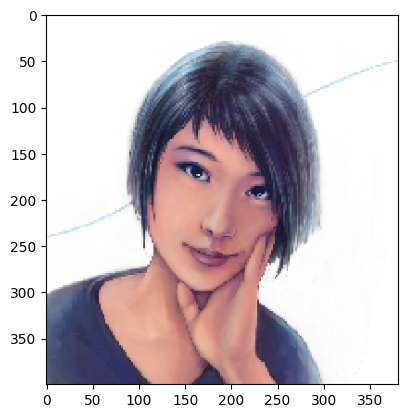

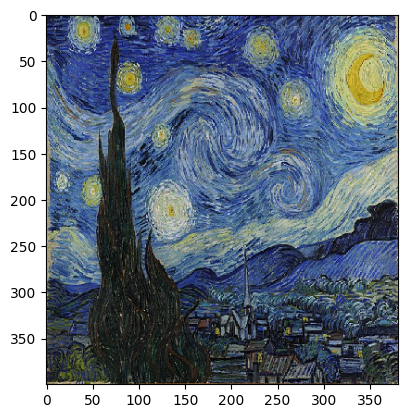

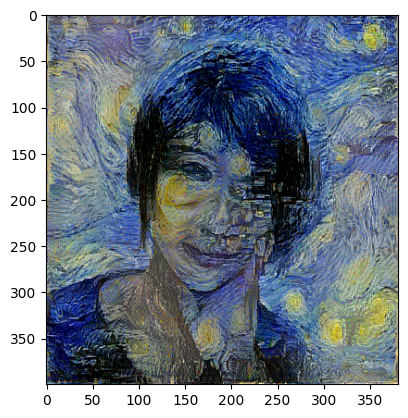

In [16]:
# 콘텐츠 이미지
plt.imshow(load_img(target_image_path, target_size=(img_height, img_width)))
plt.figure()

# 스타일 이미지
plt.imshow(load_img(style_reference_image_path, target_size=(img_height, img_width)))
plt.figure()

# 생성된 이미지
plt.imshow(img)
plt.show()